In [2]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity,\
                 constraint_matrix_to_rules, calc_constraint_error
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order, print_rules
from clustering import make_clustering
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [3]:
with open('task_with_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [5]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                               explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                                 explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.test.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.test.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [37:09,  2.29s/it]                         
Exact explainer: 978it [44:33,  2.75s/it]                         

CPU times: user 3h 55min 47s, sys: 13min 35s, total: 4h 9min 22s
Wall time: 1h 21min 42s


# Traditional SHAP Explanations

In [13]:
with open('indiv.test.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [14]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

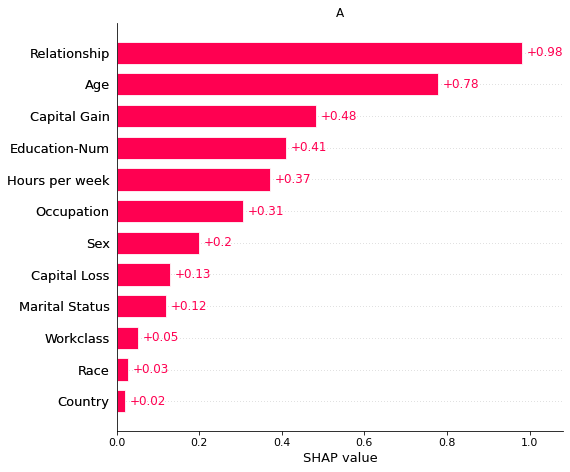

In [15]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

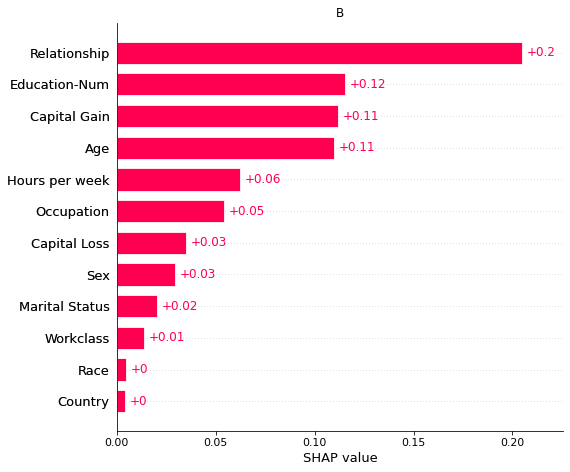

In [16]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [17]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 185 ms, sys: 16.2 ms, total: 201 ms
Wall time: 120 ms


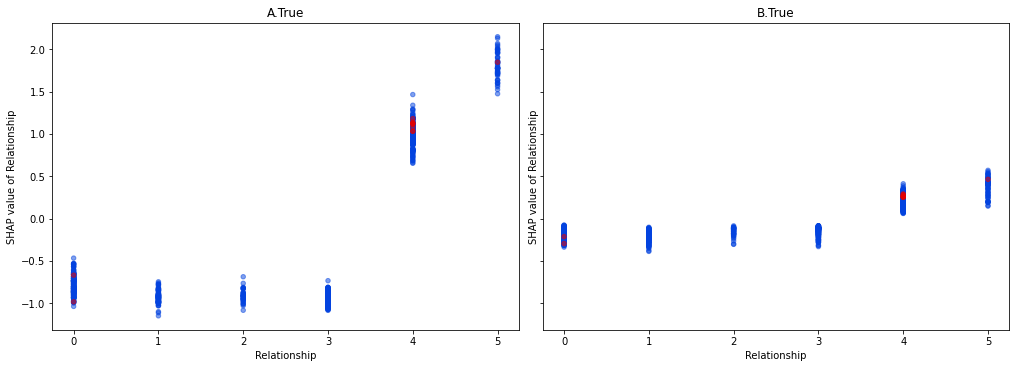

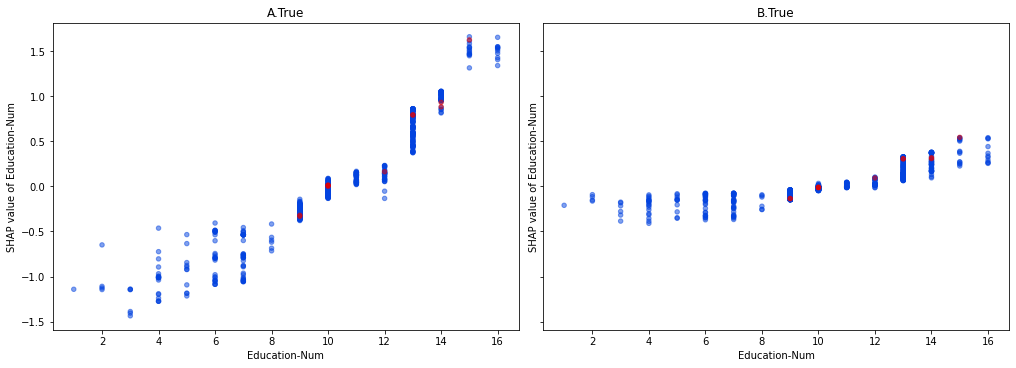

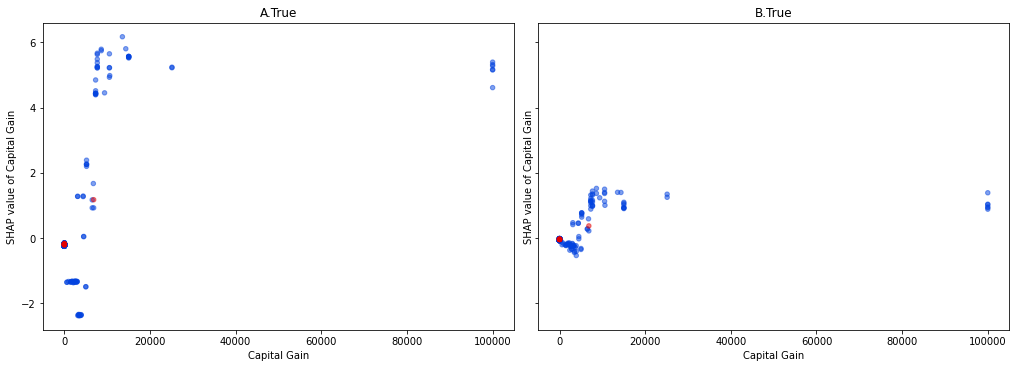

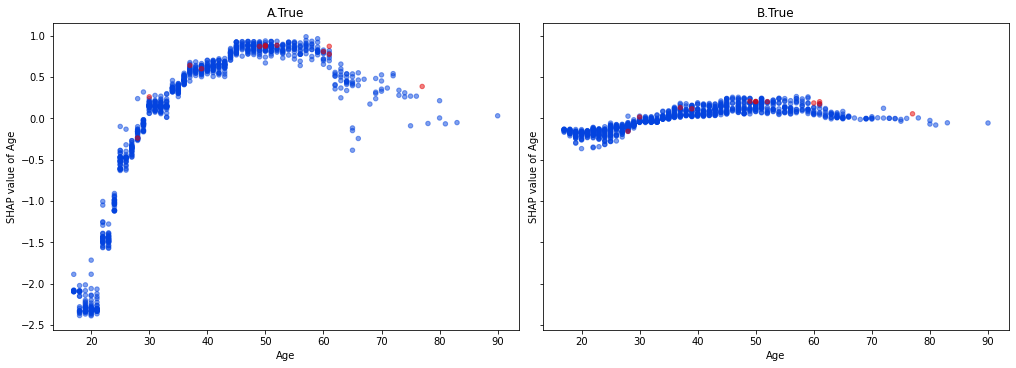

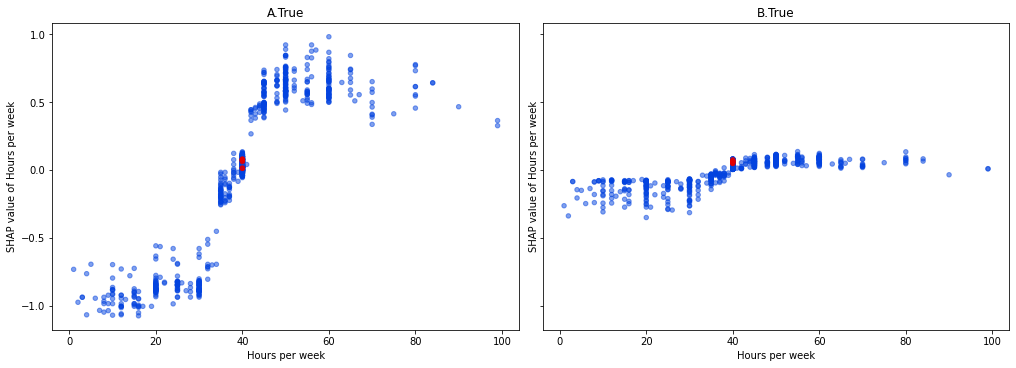

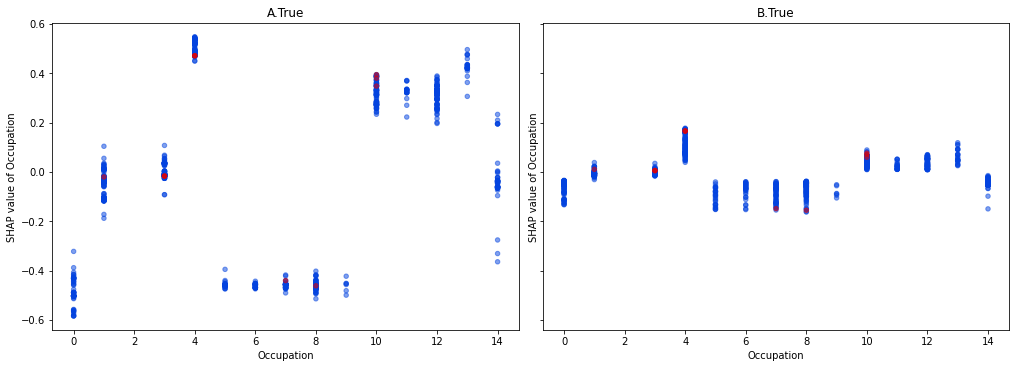

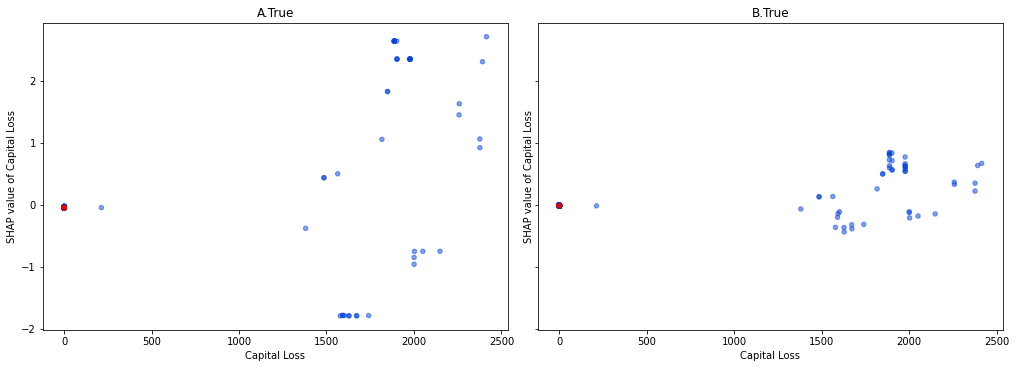

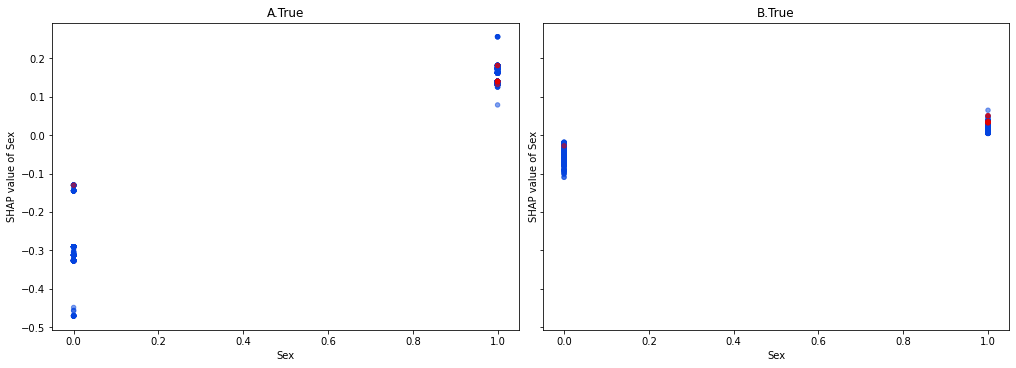

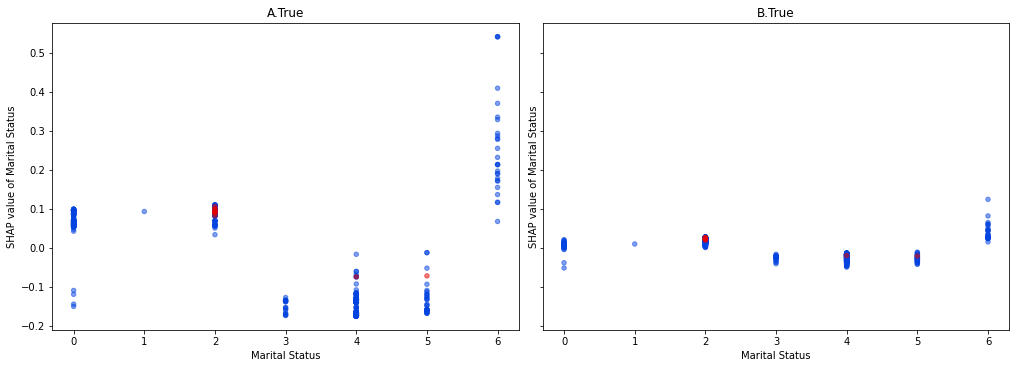

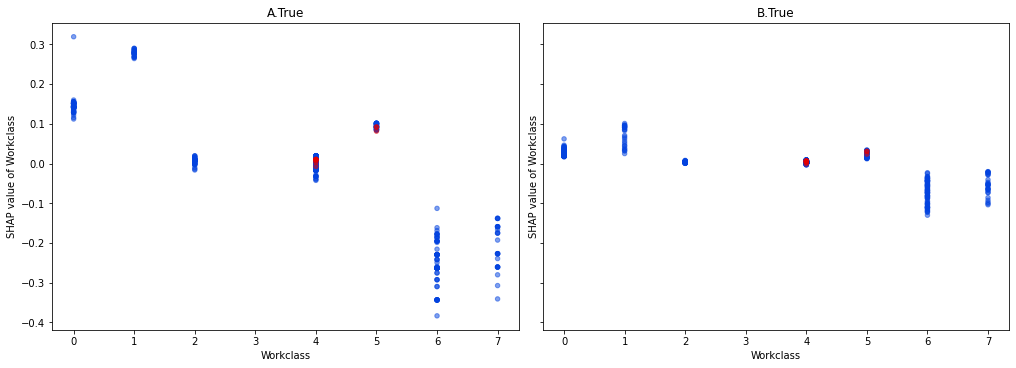

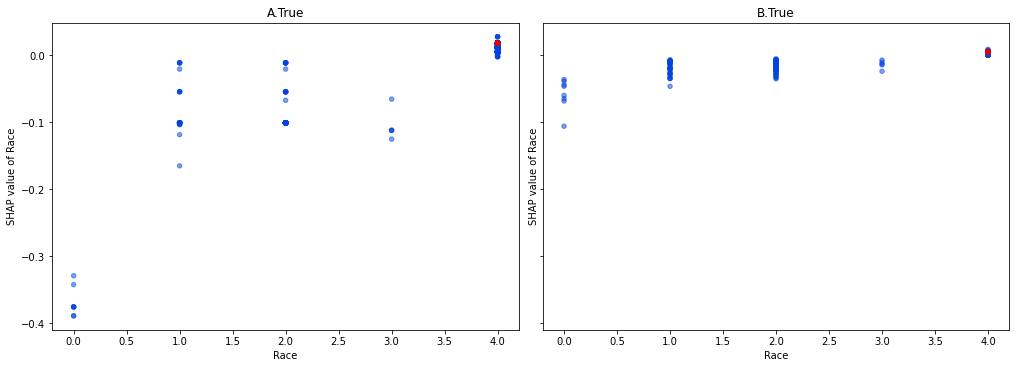

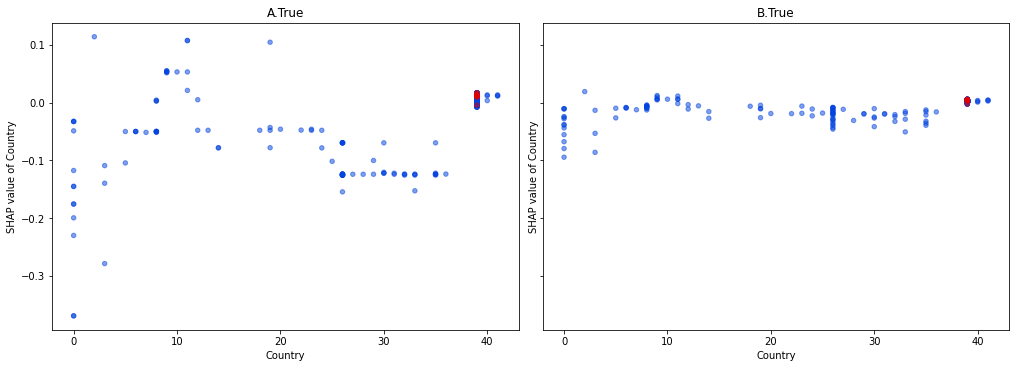

In [18]:
for feature in feature_order:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [5]:
with open('diffclf.test.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

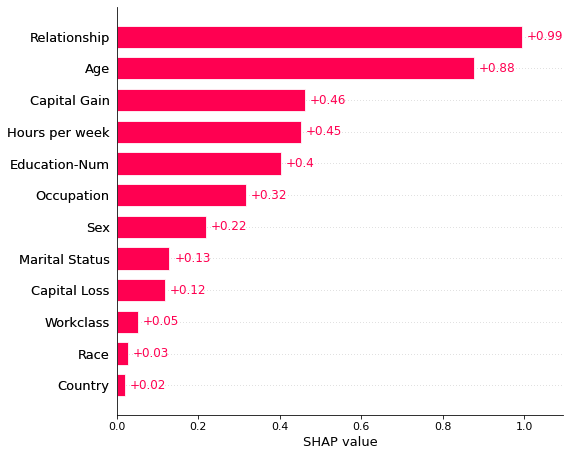

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

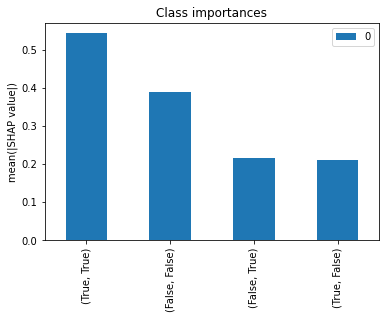

In [7]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [8]:
def plot(feature):
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    node.root.plot_feature_dependence(feature, focus=ref_node, alpha=0.5)

In [9]:
def plot_2d(node, x, y):
    comparer.plot_decision_boundaries(node.root.data, type='bin-diffclf', x=x, y=y, alpha=0.5, show=False)
    for cf in node.counterfactuals[x]:
        plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
    for cf in node.counterfactuals[y]:
        plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [10]:
fidelities_to_orig = {}

## Clustering of Class $(False, True)$ SHAP Values

In [11]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(False, True)',
                       ['(False, False)', '(False, True)', '(True, True)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 8min 2s, sys: 33.6 s, total: 8min 35s
Wall time: 2min 46s


((False, False)    786
 (True, True)      179
 (False, True)      12
 dtype: int64,
 345.2132491825516)

In [12]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

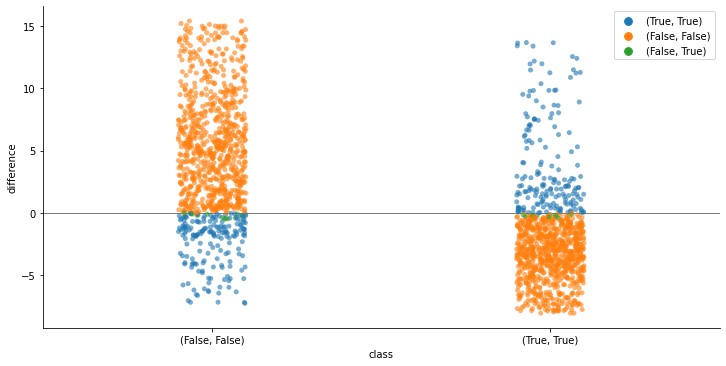

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.09'}


In [13]:
node.plot_outcome_differences()

### Main Node (R)

It's the same cluster node, with slightly different numbers of instances of classes $(False, False)$ and $(True, True)$.

In [14]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (False, False)    786
 (True, True)      138
 (False, True)      12
 dtype: int64,
 145.5470255555808)

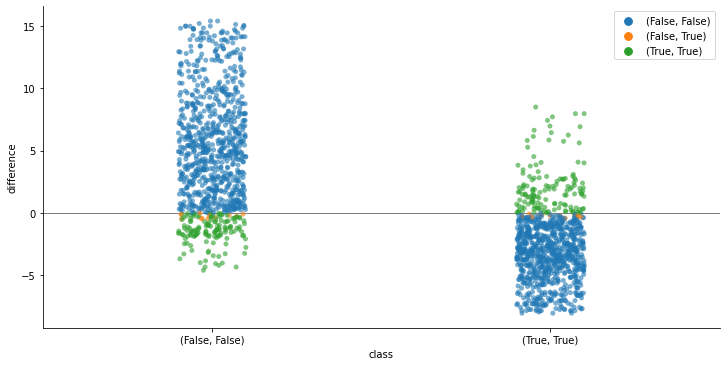

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.09'}


In [15]:
ref_node = node
node.plot_outcome_differences()

In [24]:
feature_it = iter(node.features_with_counterfactuals)

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 12},
 Upper CF: Age == 80.0 --> {'(False, False)': 11, '(True, True)': 1}]


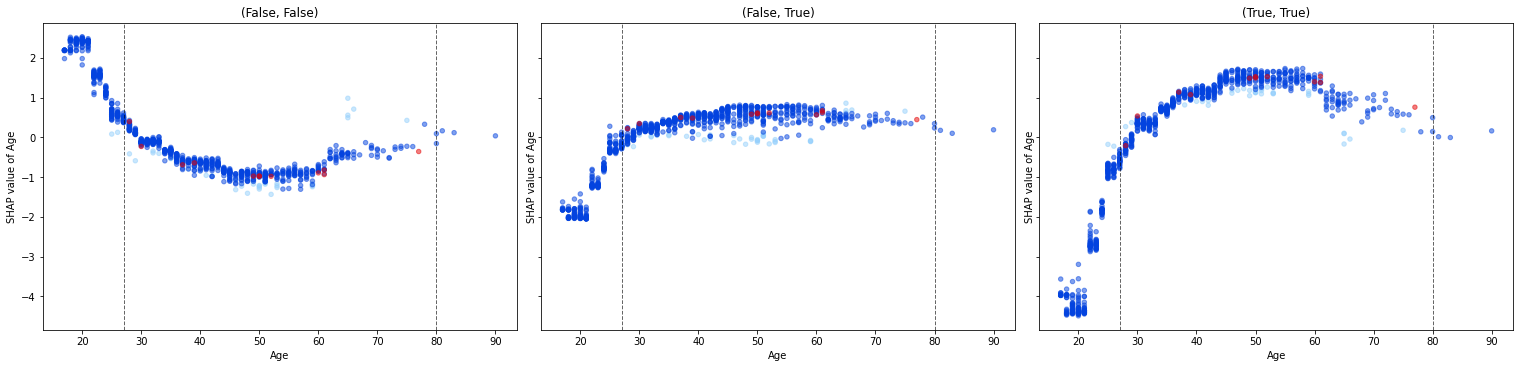

In [25]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 12},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 12}]


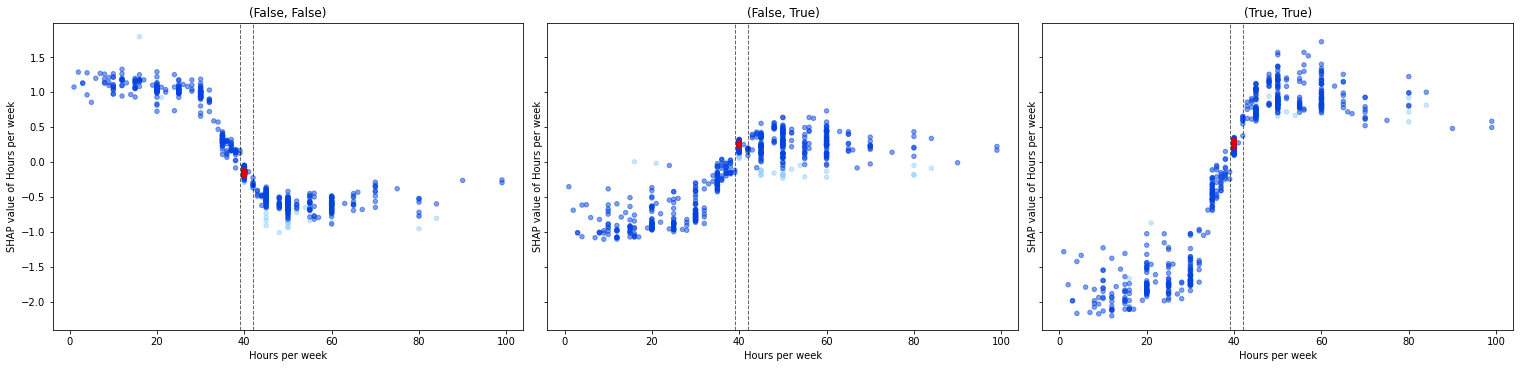

In [26]:
plot(next(feature_it))

9.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 12}]


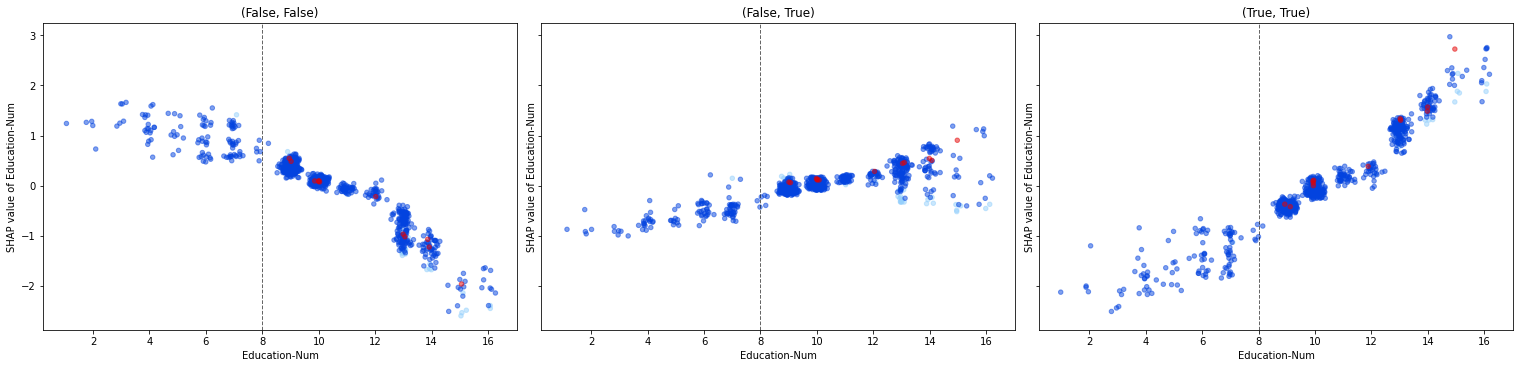

In [27]:
plot(next(feature_it))

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 12}]


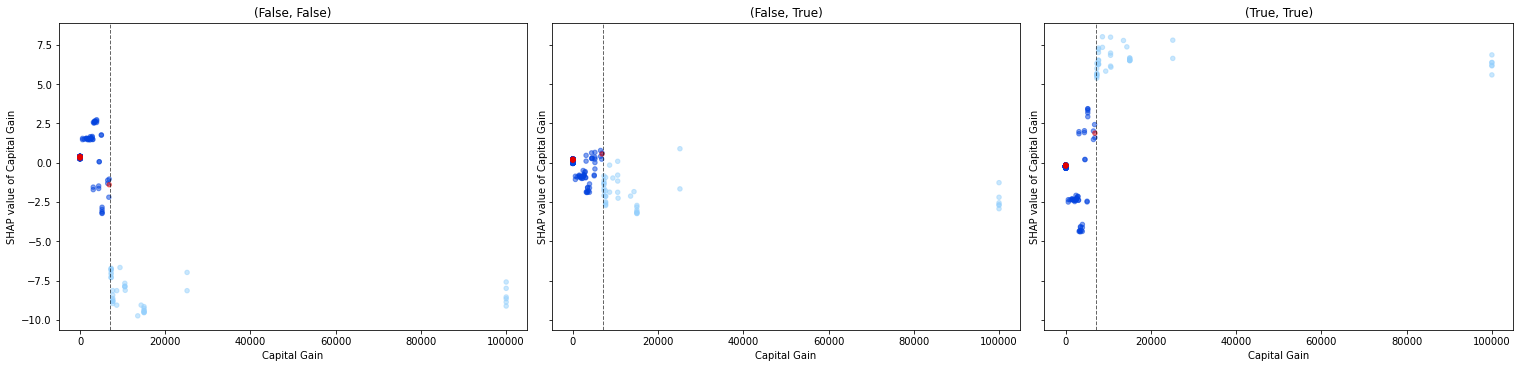

In [28]:
plot(next(feature_it))

Now ranked before Marital Status

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 12}]


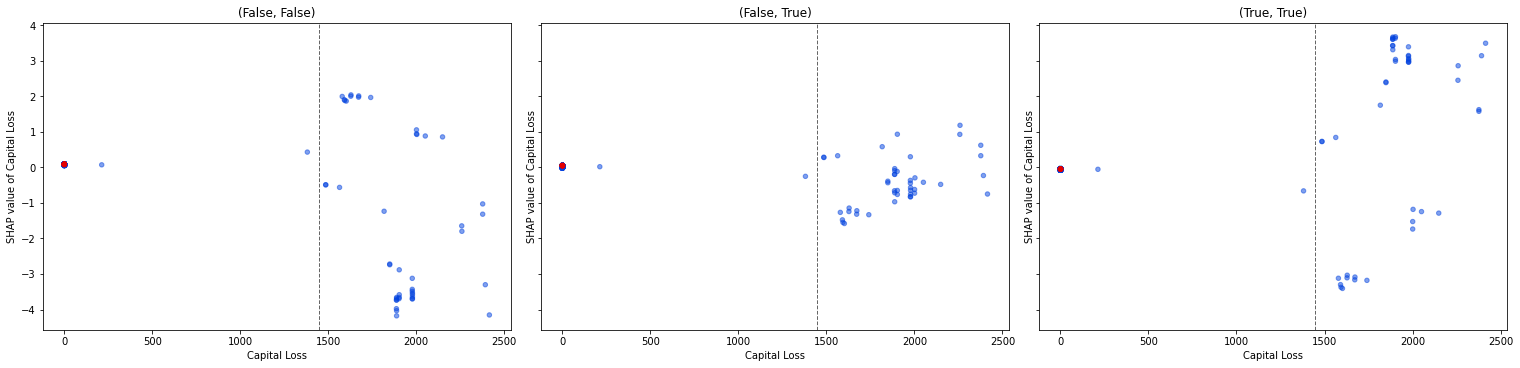

In [29]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 12}]


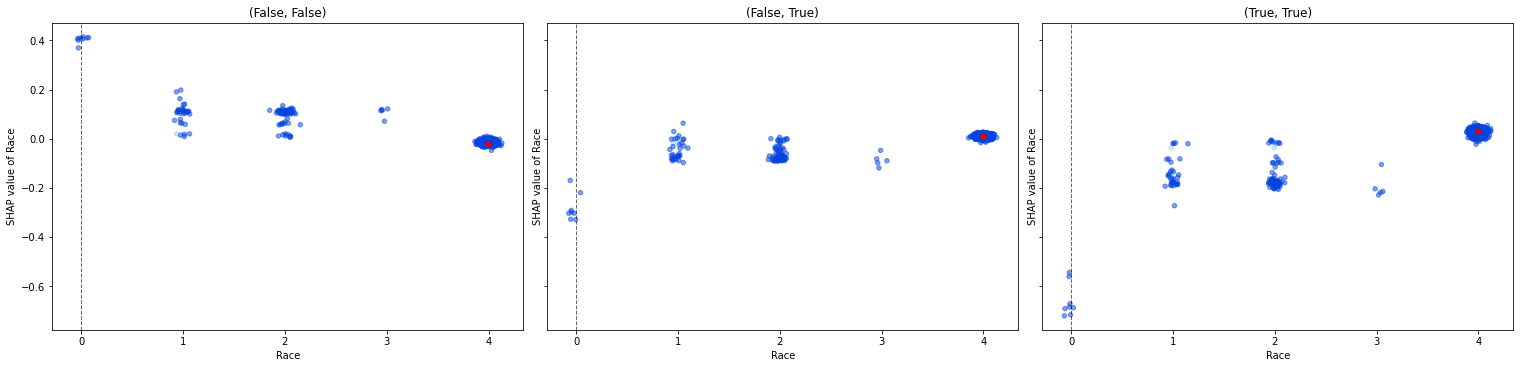

In [30]:
plot(next(feature_it))

In [31]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Age', 'Hours per week', 'Education-Num', 'Capital Gain')
print(rule)
node.root.evaluate_rules(rule)

27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       965
        True       0.04      1.00      0.08        12

    accuracy                           0.73       977
   macro avg       0.52      0.86      0.46       977
weighted avg       0.99      0.73      0.83       977



Precision    Recall  F1 Score  Support
False   1.000000  0.724352  0.840144      965
True    0.043165  1.000000  0.082759       12

In [32]:
explanations_global = [(rule, constraint, instance_indices)]

### Node 1 (RLRLR)

It's the same cluster node, with the count of class $(False, False)$ instances being slightly smaller (170-8)

In [33]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLR,
 (False, False)    162
 (False, True)       2
 (True, True)        2
 dtype: int64,
 51.51314638142301)

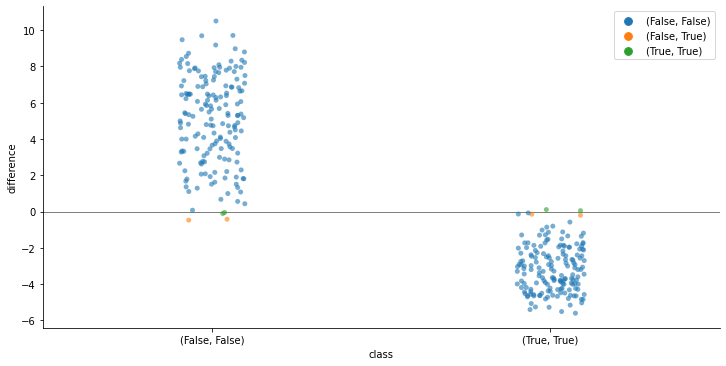

{'(False, False)': '-0.47 to -0.42', '(True, True)': '-0.2 to -0.15'}


In [34]:
ref_node = node
ref_node.plot_outcome_differences()

In [35]:
feature_it = iter(node.features_with_counterfactuals)

Relationship: different, Counterfactual changed from 1 to 4

Relationship == 0.0
[Upper CF: Relationship == 4.0 --> {'(True, True)': 2}]


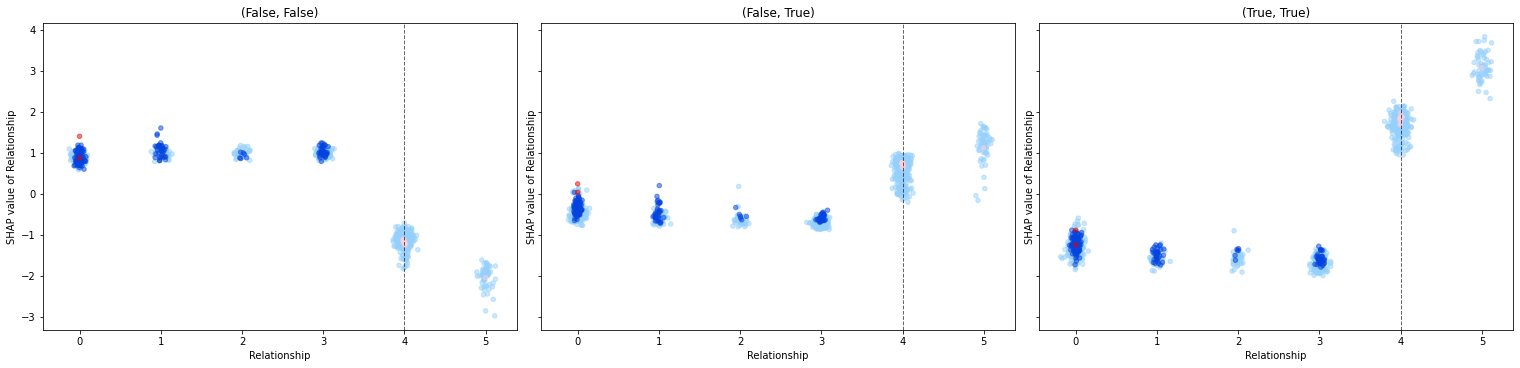

In [36]:
plot(next(feature_it))

similar, was previously ranked after Age, is now before

14.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 13.0 --> {'(False, False)': 2}]


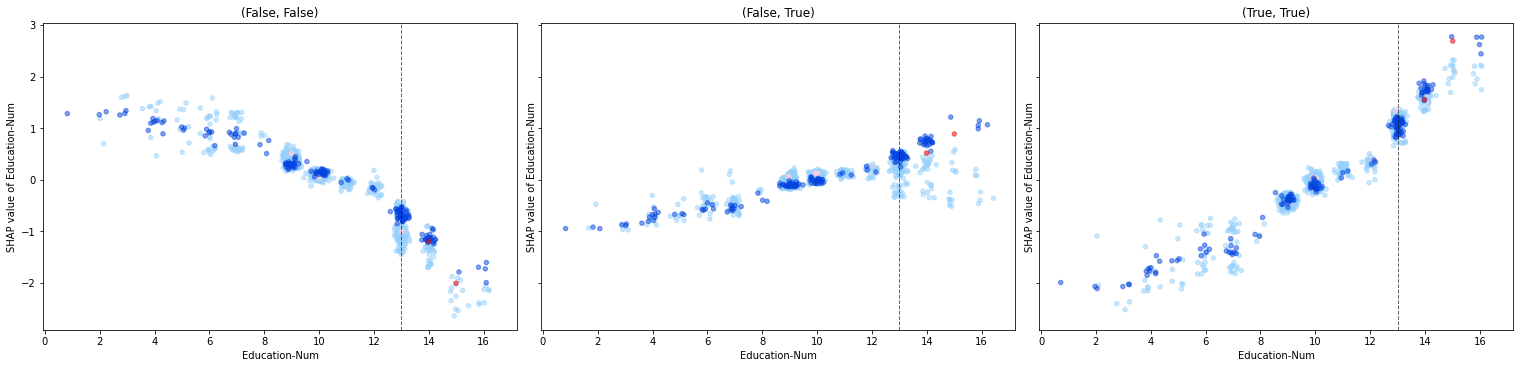

In [37]:
plot(next(feature_it))

Counterfactuals have changed ($\leq 36 \Rightarrow \leq 29$, $\geq 66 \Rightarrow \geq 80$)

39.0 <= Age <= 61.0
[Lower CF: Age == 29.0 --> {'(False, False)': 2},
 Upper CF: Age == 80.0 --> {'(False, False)': 2}]


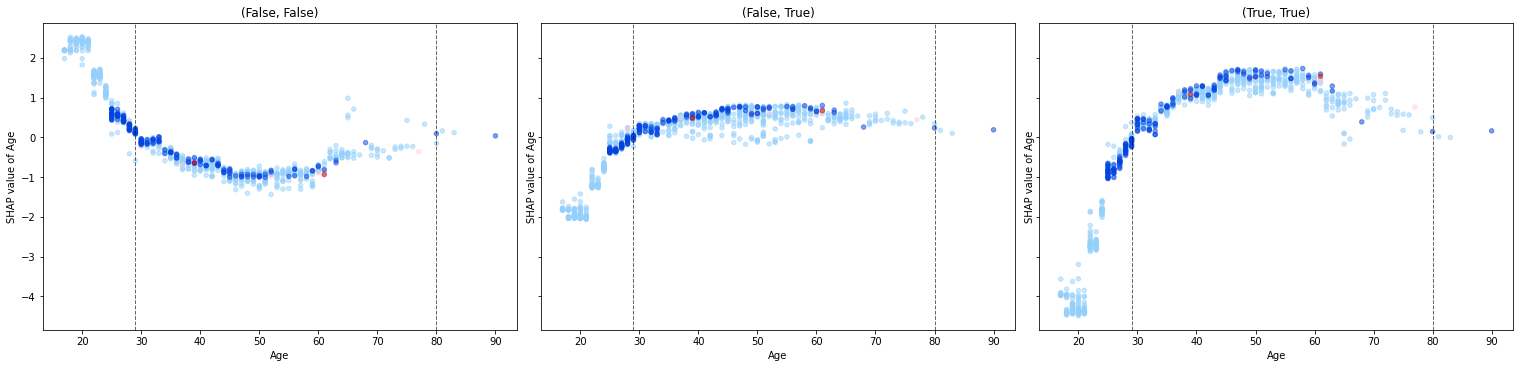

In [38]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 2},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 2}]


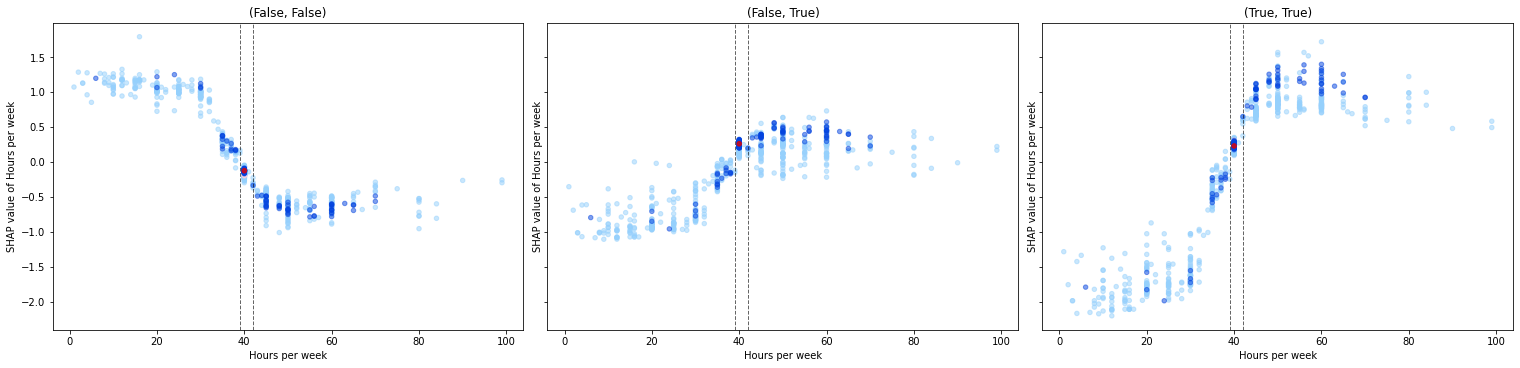

In [39]:
plot(next(feature_it))

Occupation == 10.0
[Lower CF: Occupation == 9.0 --> {'(False, False)': 2},
 Upper CF: Occupation == 14.0 --> {'(False, False)': 2}]


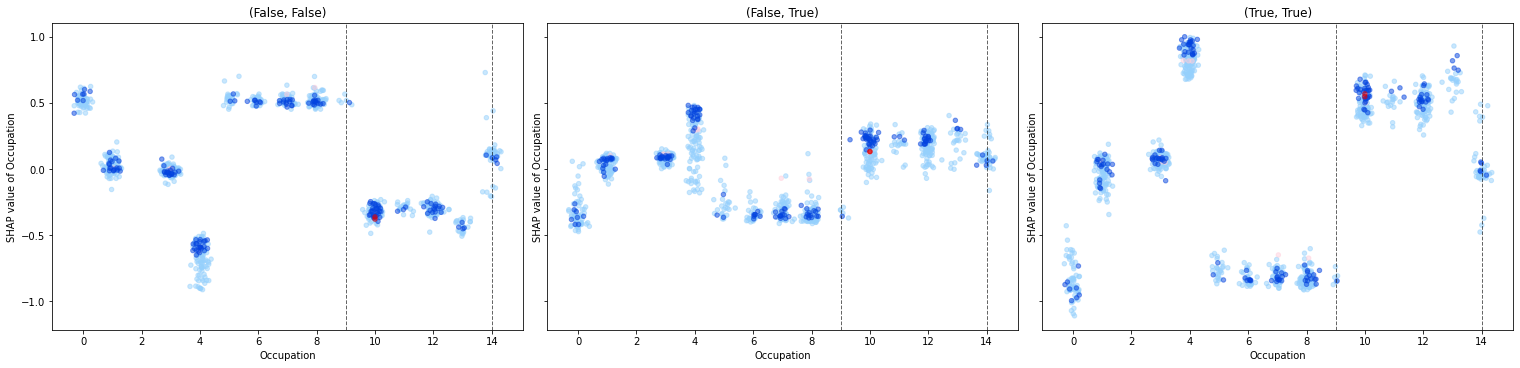

In [40]:
plot(next(feature_it))

Sex == 1.0
[Lower CF: Sex == 0.0 --> {'(False, False)': 2}]


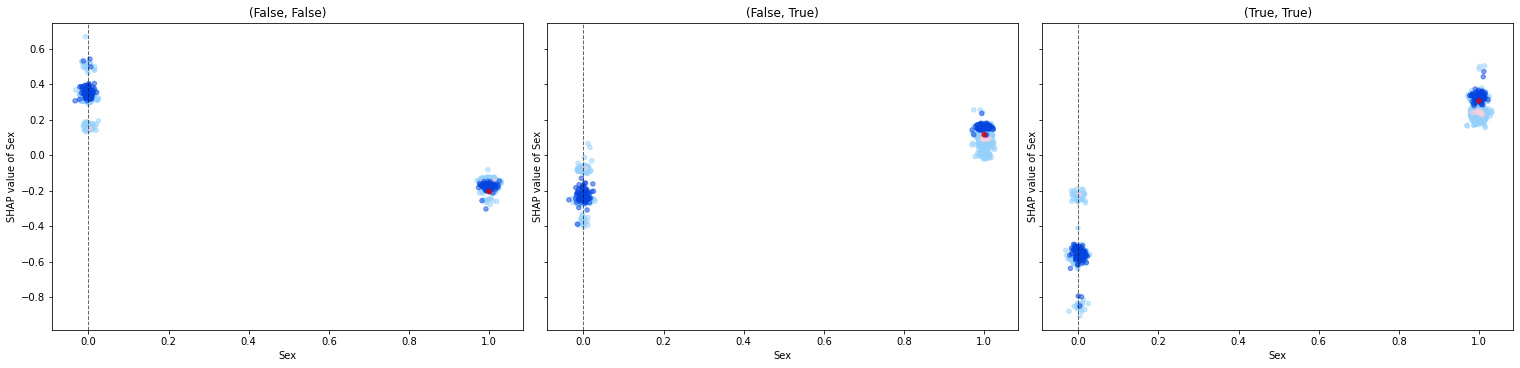

In [41]:
plot(next(feature_it))

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 2}]


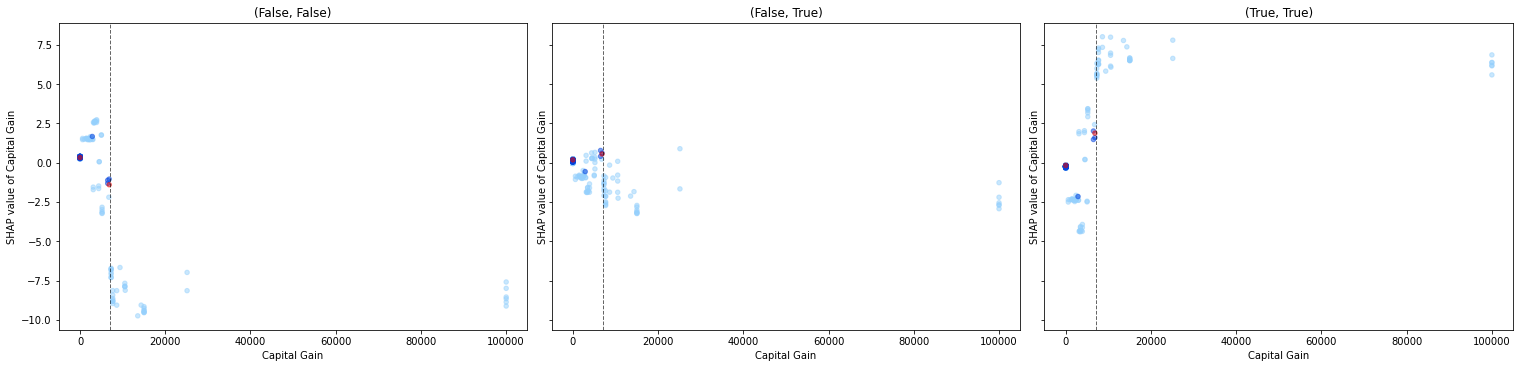

In [42]:
plot(next(feature_it))

Still, the local performance is equal.

In [43]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Education-Num', 'Hours per week', 'Occupation', 'Sex', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

Relationship <= 3.0 and `Education-Num` > 13.0 and 29.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       164
        True       0.50      1.00      0.67         2

    accuracy                           0.99       166
   macro avg       0.75      0.99      0.83       166
weighted avg       0.99      0.99      0.99       166



Precision    Recall  F1 Score  Support
False        1.0  0.987805  0.993865      164
True         0.5  1.000000  0.666667        2

In [44]:
explanations_l1 = [(rule, constraint, instance_indices)]

### Node 2 (RRRRR)

In [45]:
node = node.root.get('RR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRR,
 (False, False)    178
 (True, True)      103
 (False, True)      10
 dtype: int64,
 33.98983567154949)

There is the same number of instances classified differently, but the cluster node isn't the same. Instance counts are a bit different: $(False, False)$ has 27 more, $(True, True)$ has 7 more.

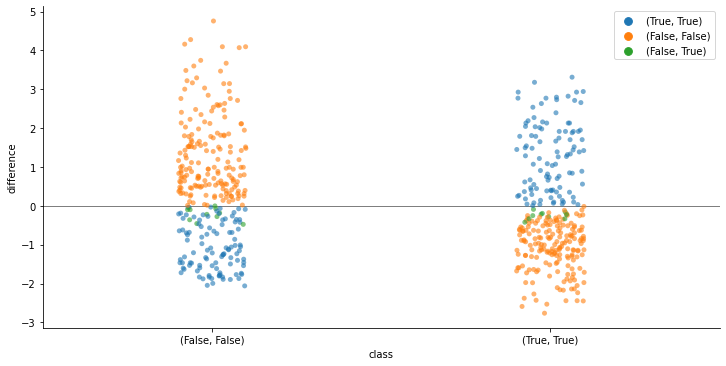

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.09'}


In [46]:
ref_node = node
ref_node.plot_outcome_differences()

In [47]:
feature_it = iter(node.features_with_counterfactuals)

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 10}]


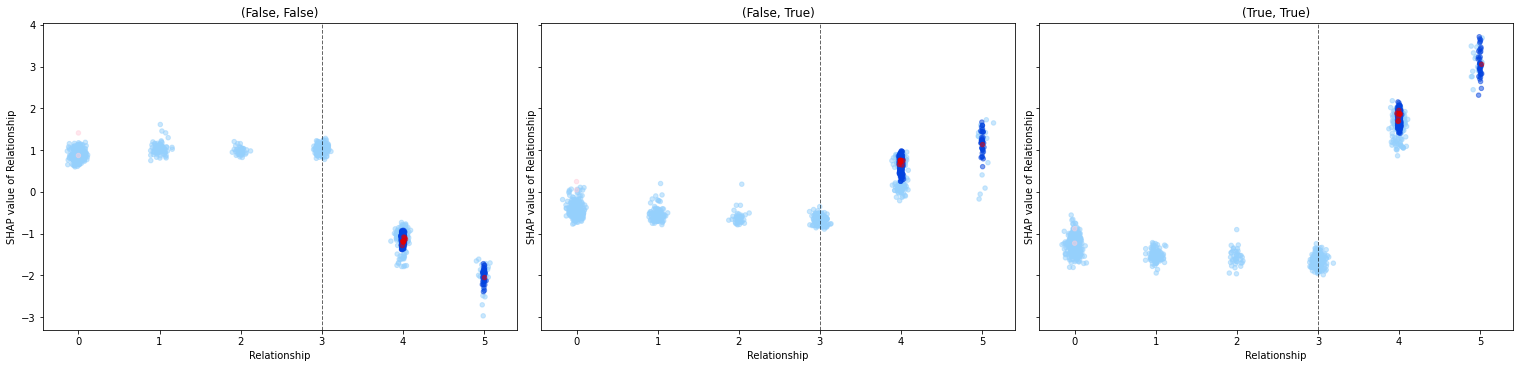

In [48]:
plot(next(feature_it))

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 10},
 Upper CF: Age == 80.0 --> {'(False, False)': 9, '(True, True)': 1}]


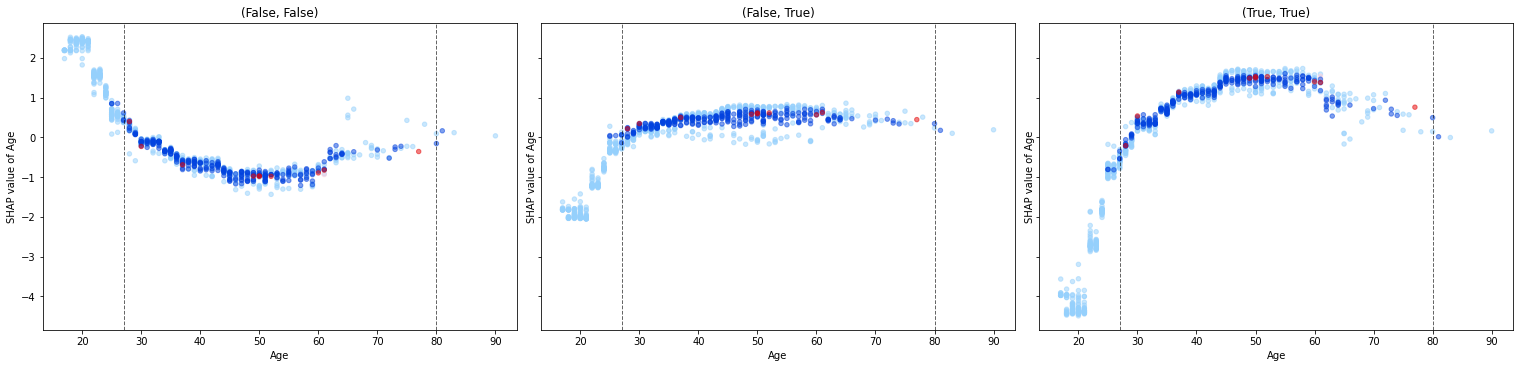

In [49]:
plot(next(feature_it))

9.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 10},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 10}]


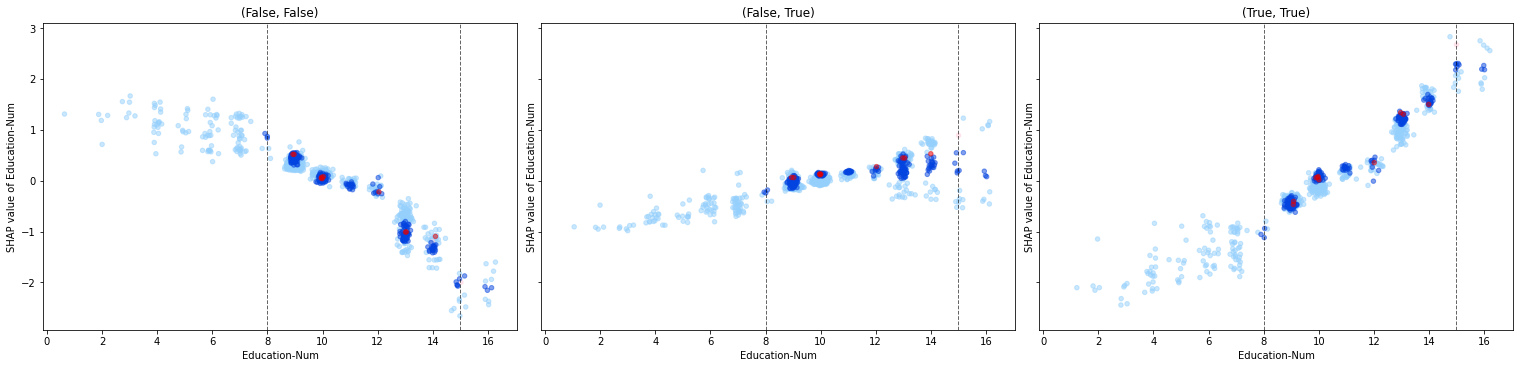

In [50]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 10},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 10}]


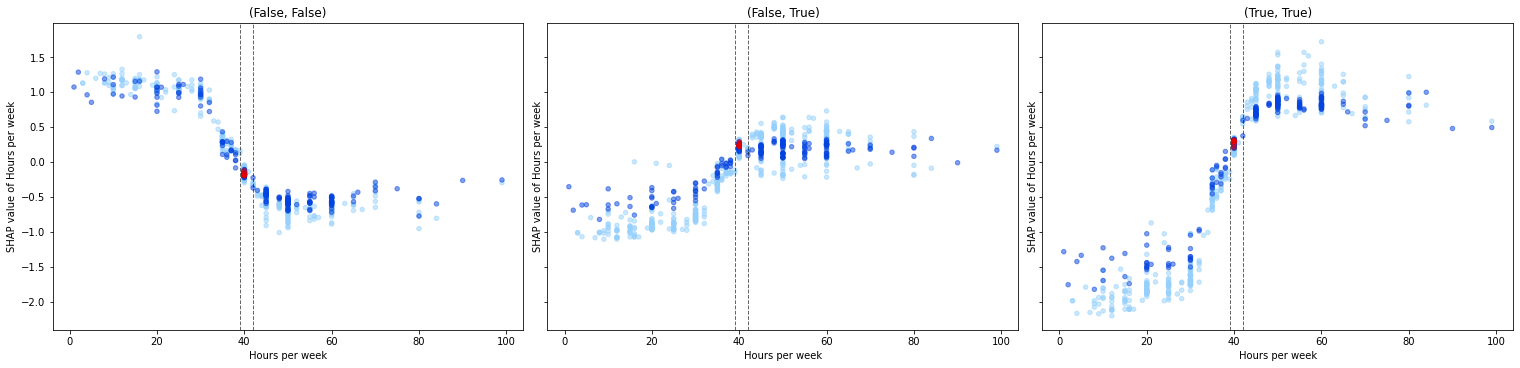

In [51]:
plot(next(feature_it))

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 10}]


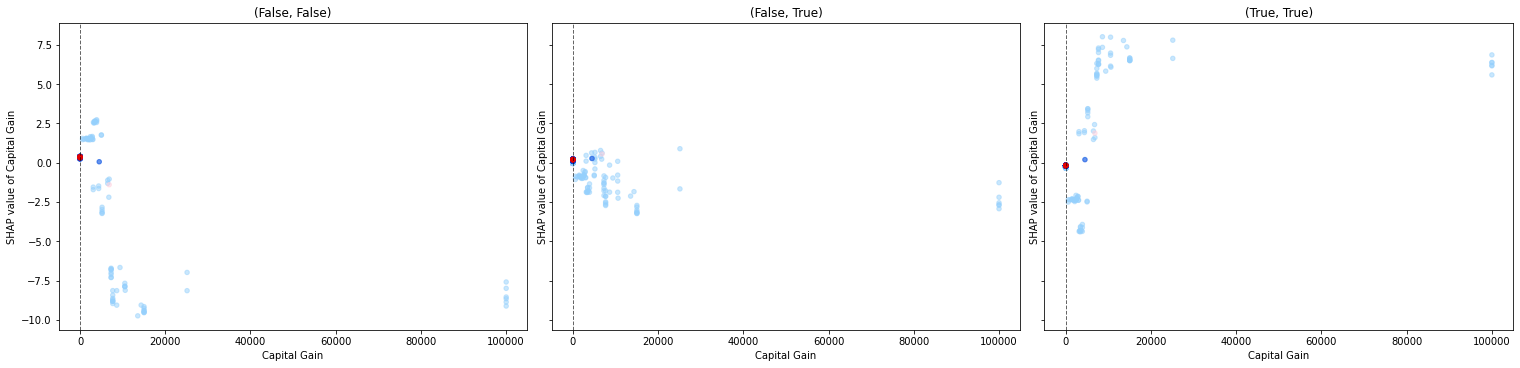

In [52]:
plot(next(feature_it))

Now ranked before Race

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 10}]


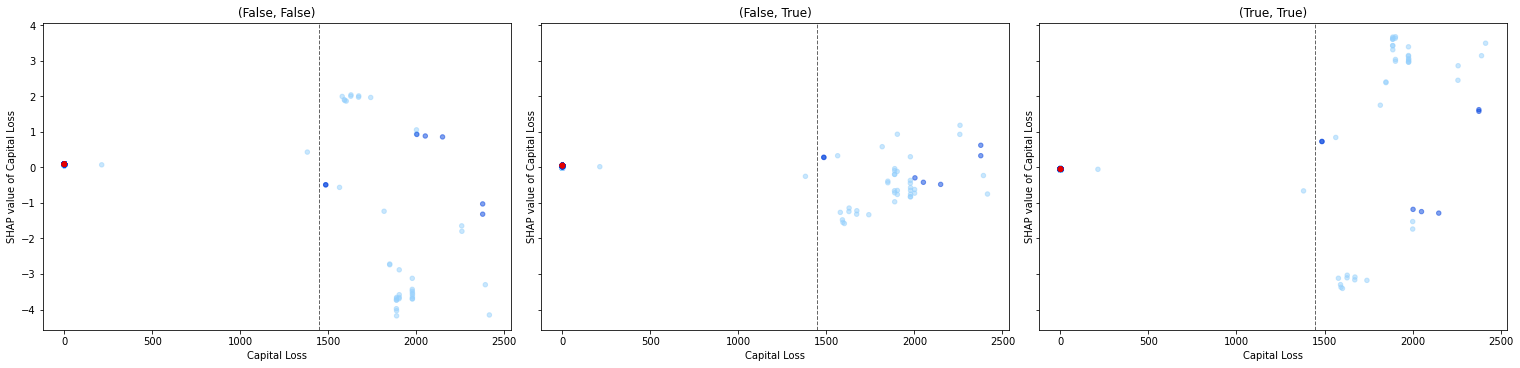

In [53]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 10}]


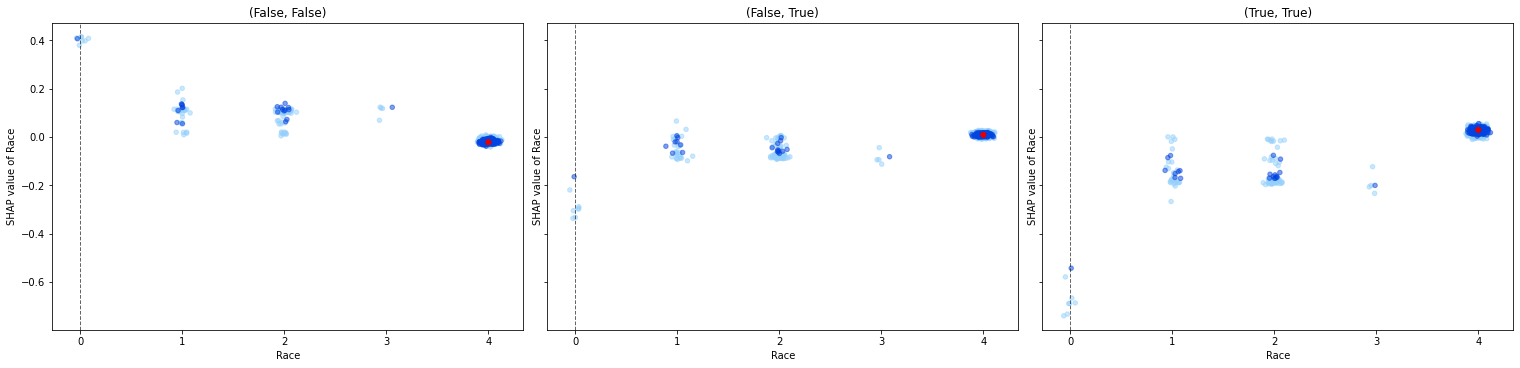

In [54]:
plot(next(feature_it))

Marital Status has no CF here

Still the same performance

In [55]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0
              precision    recall  f1-score   support

       False       1.00      0.62      0.77       281
        True       0.09      1.00      0.16        10

    accuracy                           0.64       291
   macro avg       0.54      0.81      0.46       291
weighted avg       0.97      0.64      0.75       291



Precision    Recall  F1 Score  Support
False   1.000000  0.622776  0.767544      281
True    0.086207  1.000000  0.158730       10

In [56]:
explanations_l1.append((rule, constraint, instance_indices))

### Node 2.1 (RRRRRL)

In [57]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRL,
 (True, True)      65
 (False, False)     7
 (False, True)      3
 dtype: int64,
 14.368012741572981)

Although the cluster node is different, it has the same numbers of instances per class.

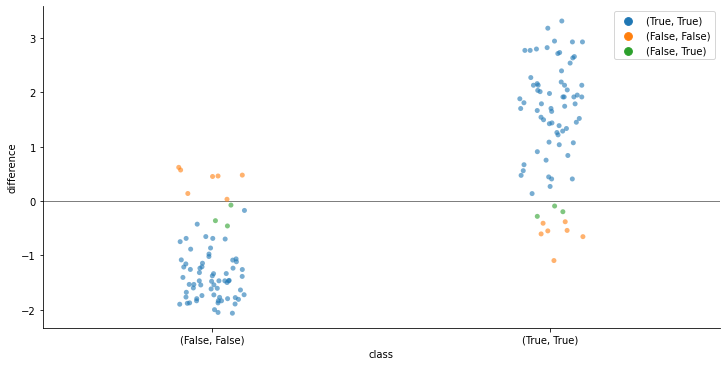

{'(False, False)': '-0.46 to -0.07', '(True, True)': '-0.28 to -0.09'}


In [58]:
ref_node = node
ref_node.plot_outcome_differences()

In [59]:
feature_it = iter(node.features_with_counterfactuals)

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 3}]


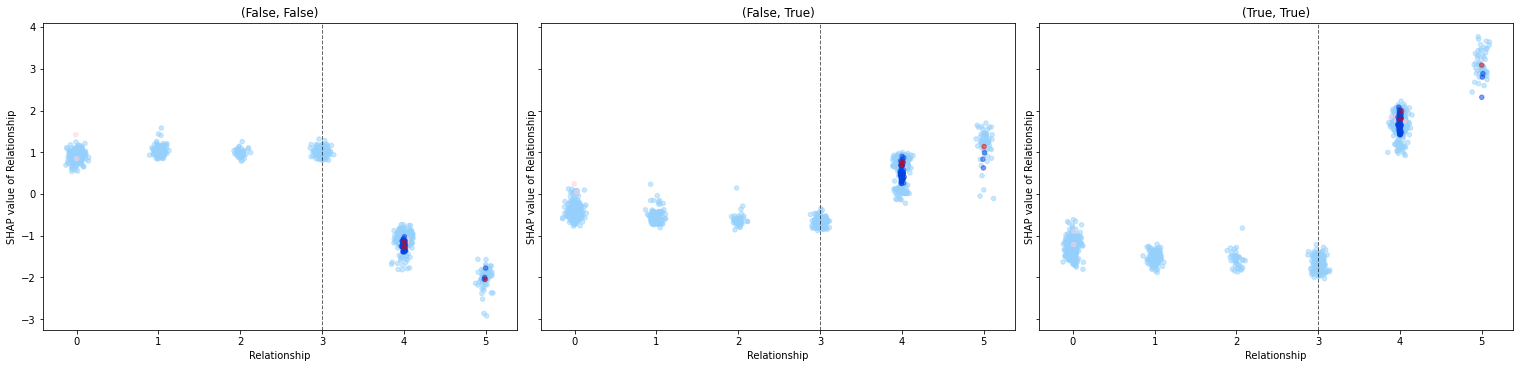

In [60]:
plot(next(feature_it))

13.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 3},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 3}]


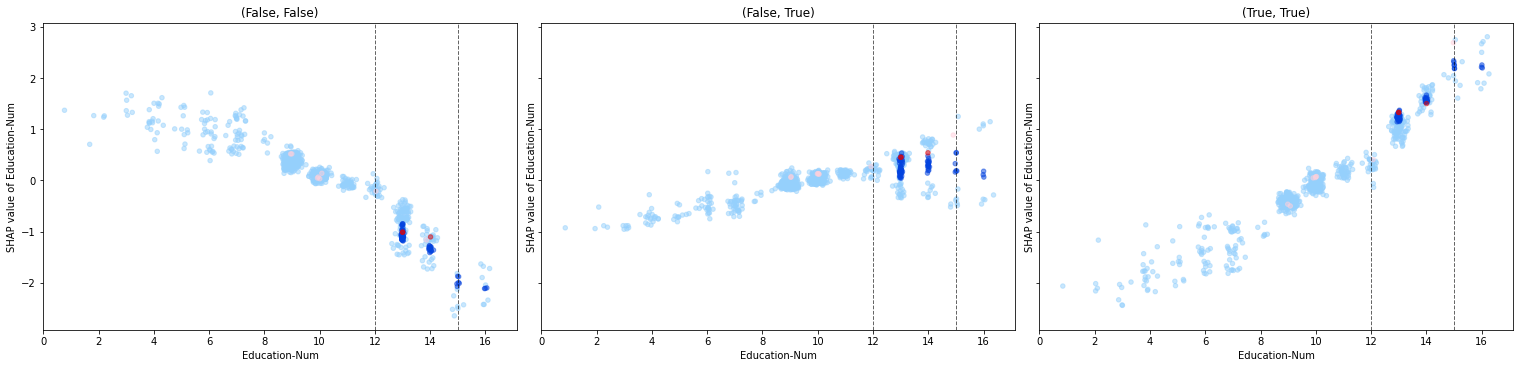

In [61]:
plot(next(feature_it))

Upper CF now lower

28.0 <= Age <= 37.0
[Lower CF: Age == 27.0 --> {'(False, False)': 3},
 Upper CF: Age == 40.0 --> {'(True, True)': 3}]


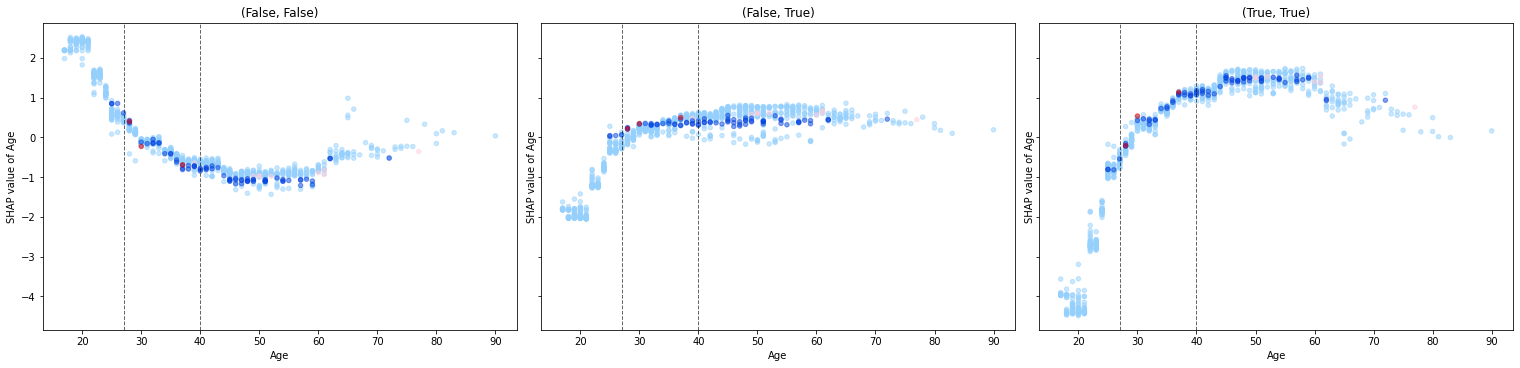

In [62]:
plot(next(feature_it))

now ranked before Occupation

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 3},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 3}]


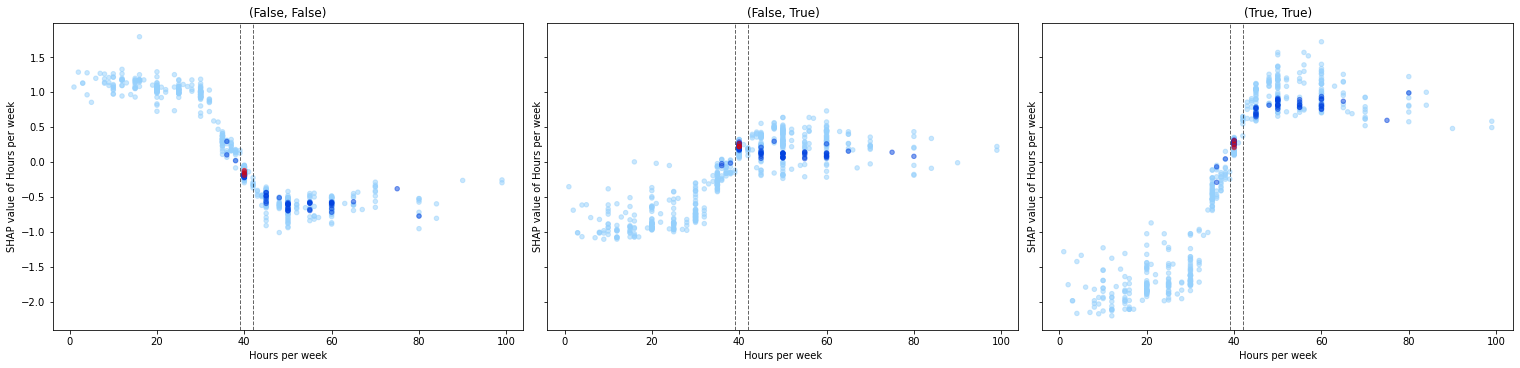

In [63]:
plot(next(feature_it))

7.0 <= Occupation <= 10.0
[Lower CF: Occupation == 3.0 --> {'(True, True)': 2, '(False, False)': 1}]


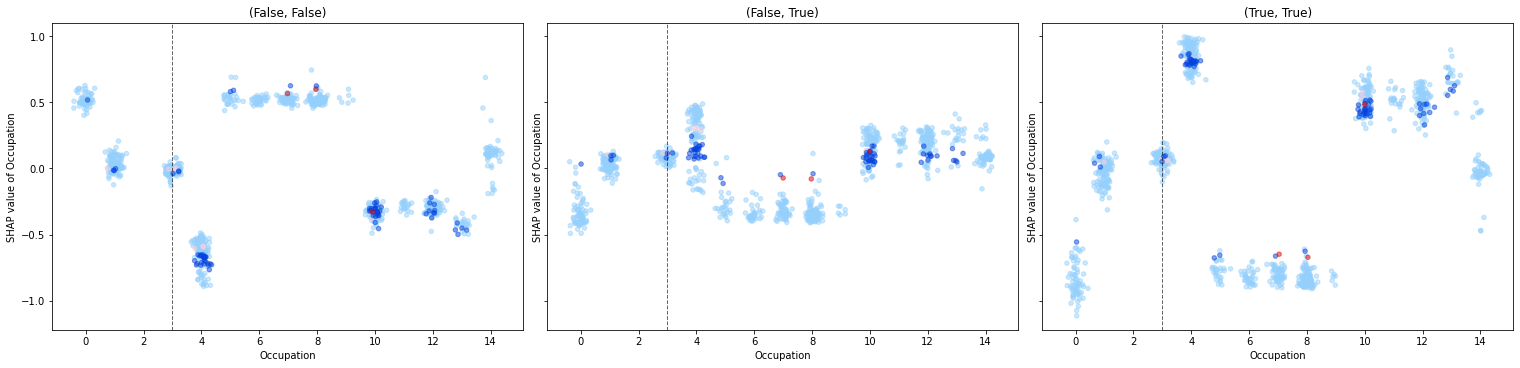

In [64]:
plot(next(feature_it))

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 3}]


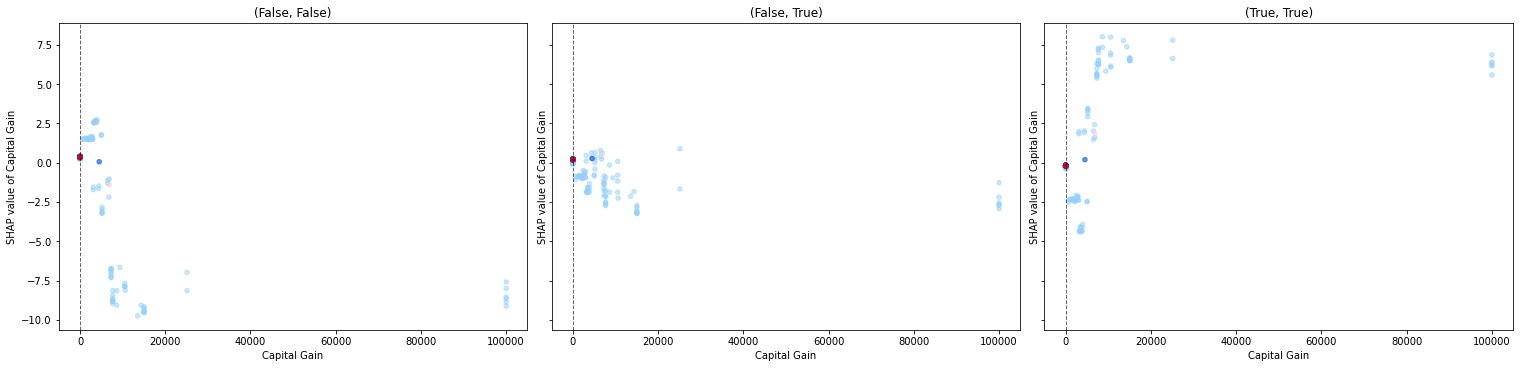

In [65]:
plot(next(feature_it))

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 3}]


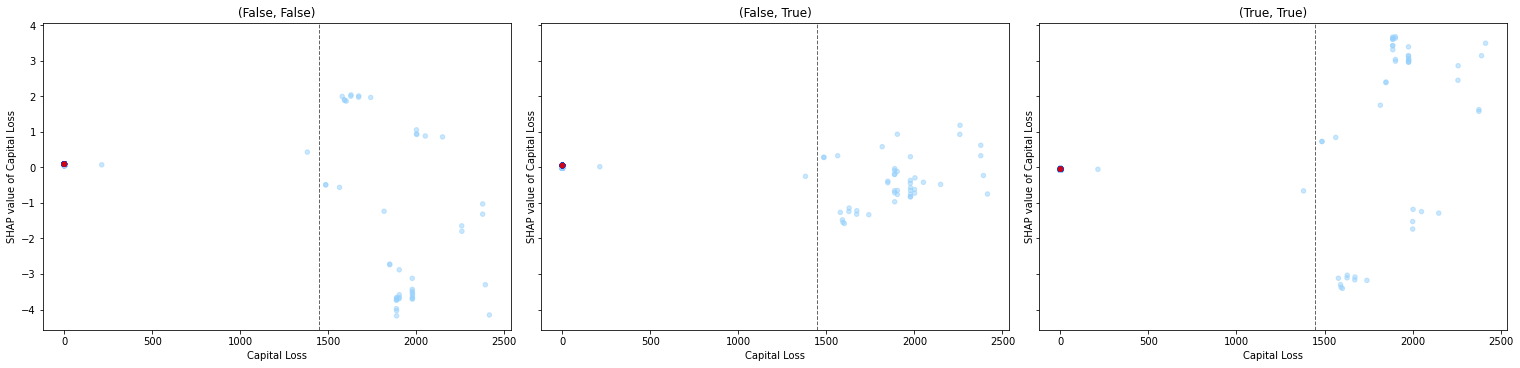

In [66]:
plot(next(feature_it))

Marital Status has no CF anymore, instead Workclass has

Workclass == 4.0
[Lower CF: Workclass == 1.0 --> {'(True, True)': 3}]


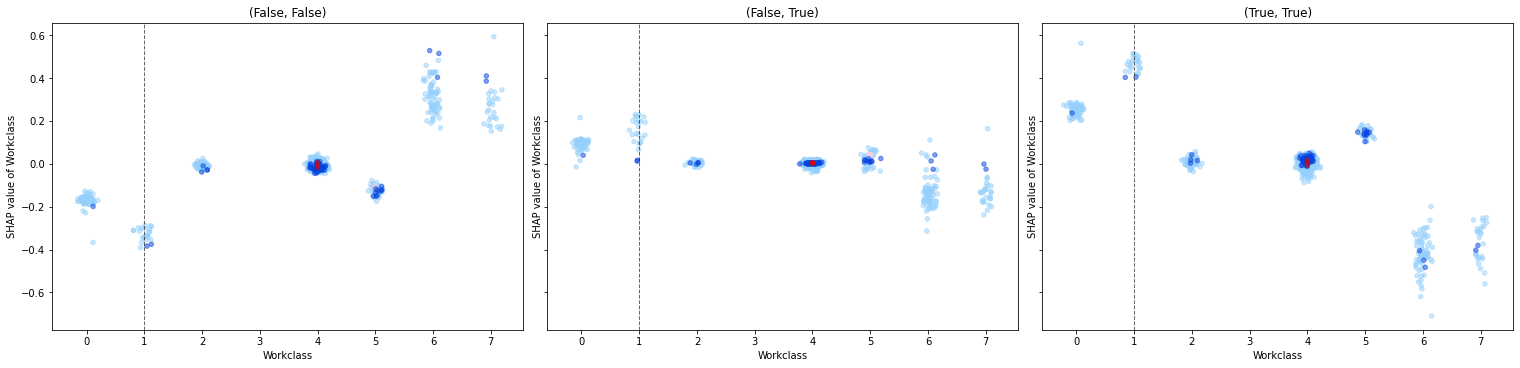

In [67]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 3}]


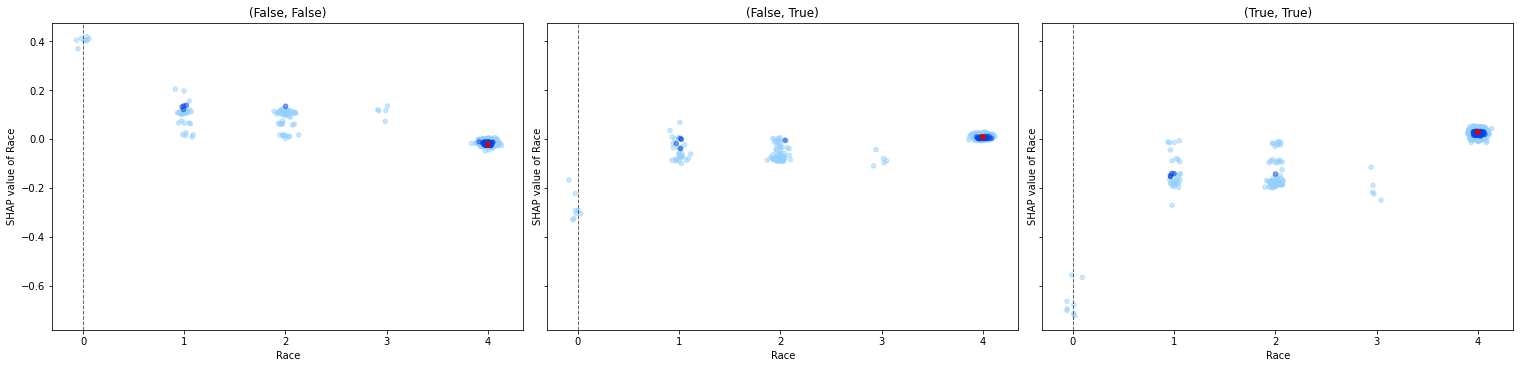

In [68]:
plot(next(feature_it))

This leads to better performance

In [69]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Education-Num', 'Age', 'Hours per week', 'Capital Gain', 'Workclass')
print(rule)
node.evaluate_rules(rule)

Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 39.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and Workclass > 1.0
              precision    recall  f1-score   support

       False       1.00      0.92      0.96        72
        True       0.33      1.00      0.50         3

    accuracy                           0.92        75
   macro avg       0.67      0.96      0.73        75
weighted avg       0.97      0.92      0.94        75



Precision    Recall  F1 Score  Support
False   1.000000  0.916667  0.956522       72
True    0.333333  1.000000  0.500000        3

In [70]:
explanations_l2 = [explanations_l1[0]]
explanations_l2.append((rule, constraint, instance_indices))

### Node 2.2 (RRRRRRRRL)

In [71]:
node = node.root.get('RRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRRRRL,
 (False, False)    102
 (True, True)       28
 (False, True)       7
 dtype: int64,
 8.355443986900394)

The number of instances in the difference class is the same, but those of $(False, False)$ is higher by 13, those of $(True, True)$ is lower by 2.

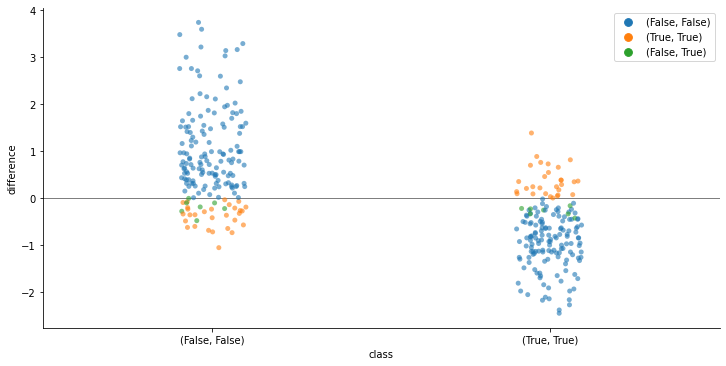

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.16'}


In [72]:
ref_node = node.parent
ref_node.plot_outcome_differences()

In [73]:
feature_it = iter(node.features_with_counterfactuals)

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 7}]


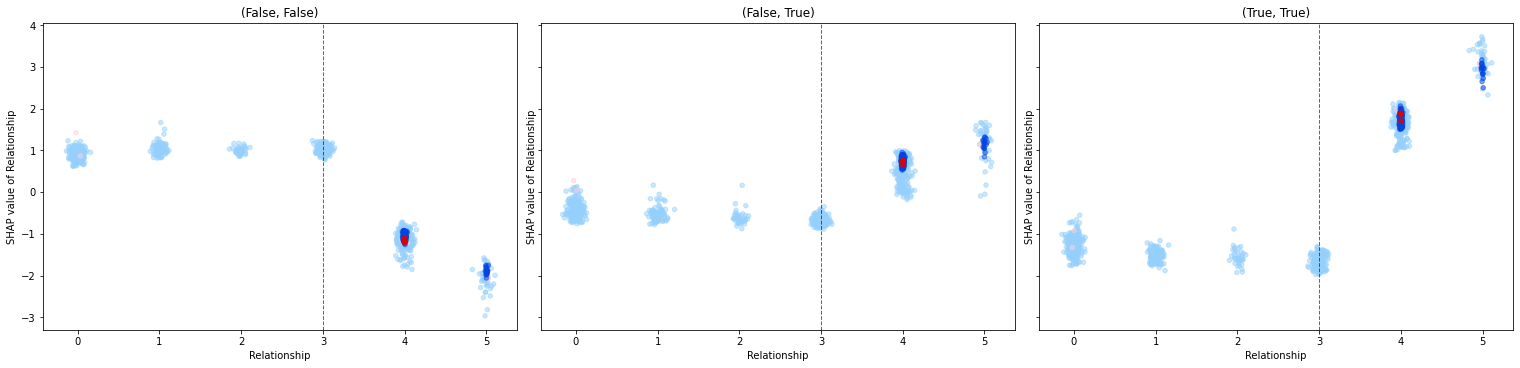

In [74]:
plot(next(feature_it))

49.0 <= Age <= 77.0
[Lower CF: Age == 33.0 --> {'(False, False)': 7},
 Upper CF: Age == 80.0 --> {'(False, False)': 7}]


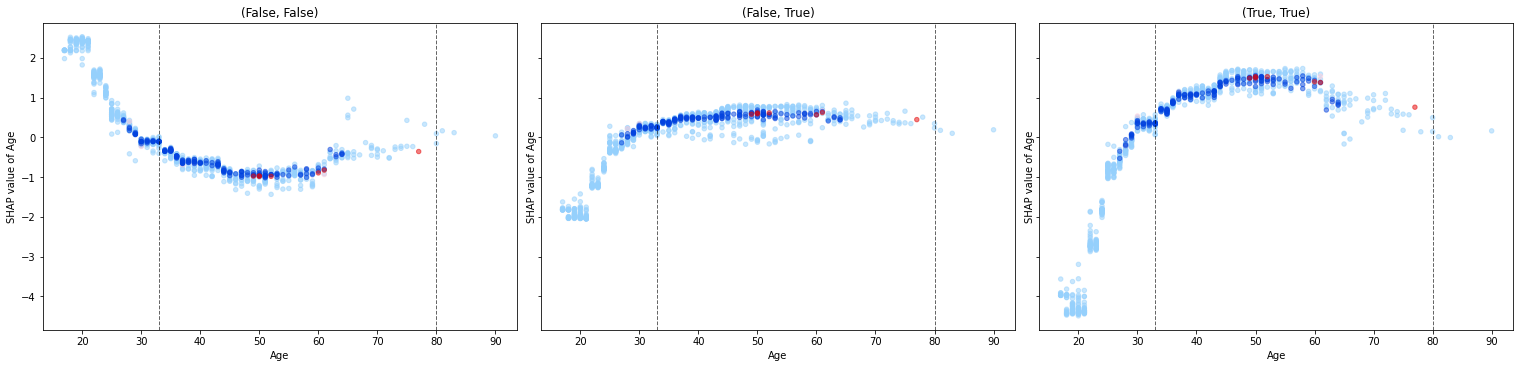

In [75]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 7},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 7}]


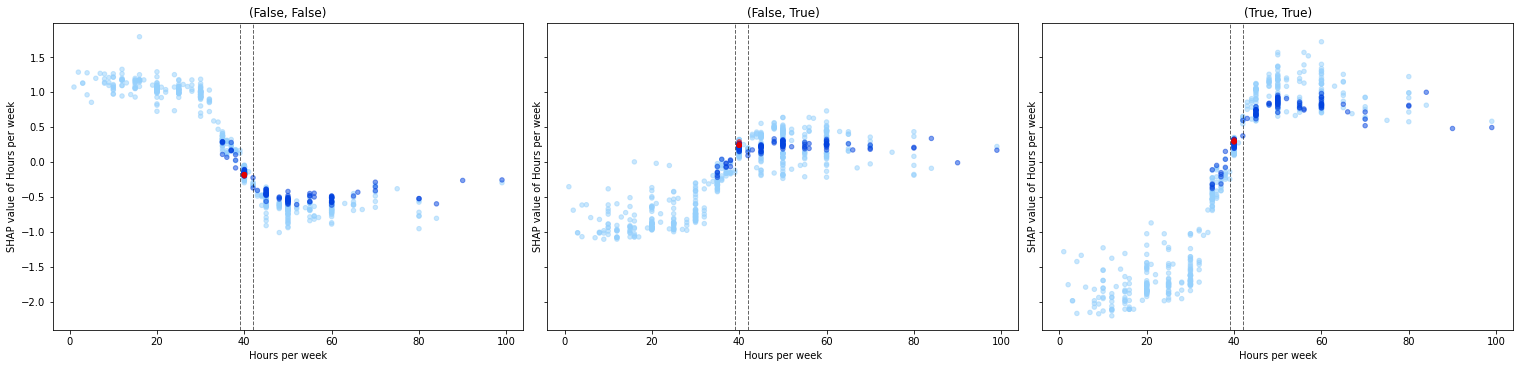

In [76]:
plot(next(feature_it))

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 7}]


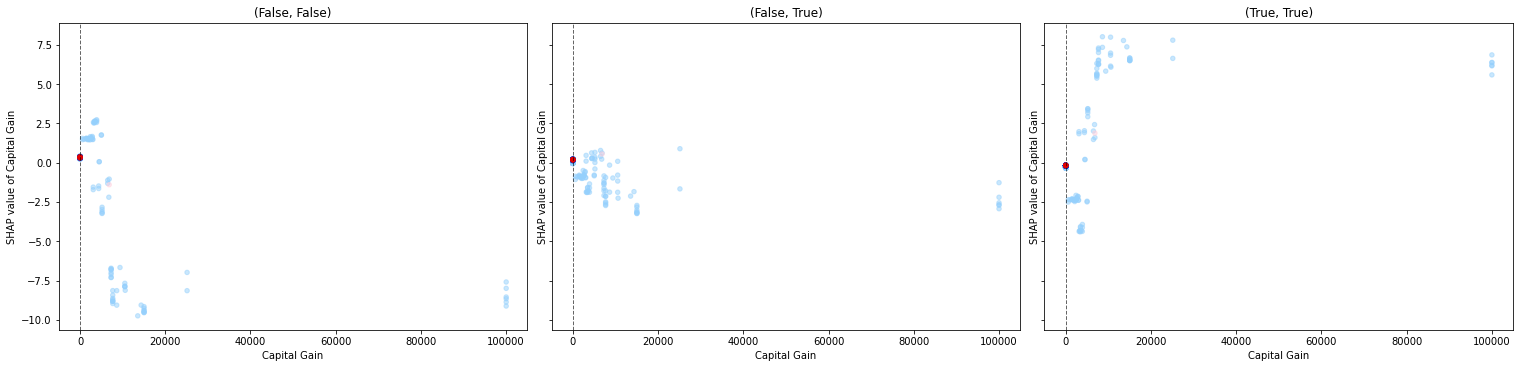

In [77]:
plot(next(feature_it))

1.0 <= Occupation <= 4.0
[Upper CF: Occupation == 5.0 --> {'(False, False)': 7}]


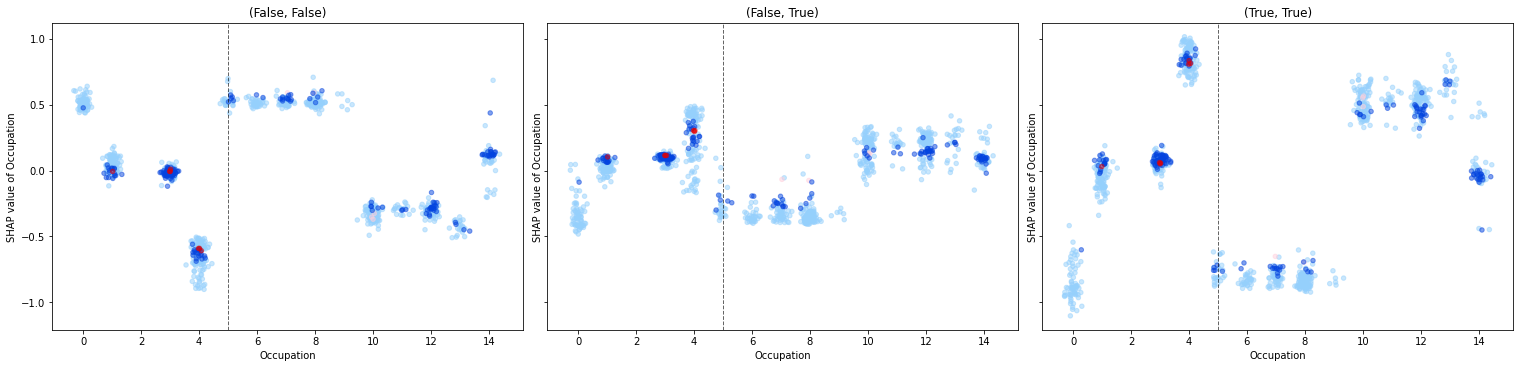

In [78]:
plot(next(feature_it))

9.0 <= Education-Num <= 12.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 7},
 Upper CF: Education-Num == 13.0 --> {'(True, True)': 7}]


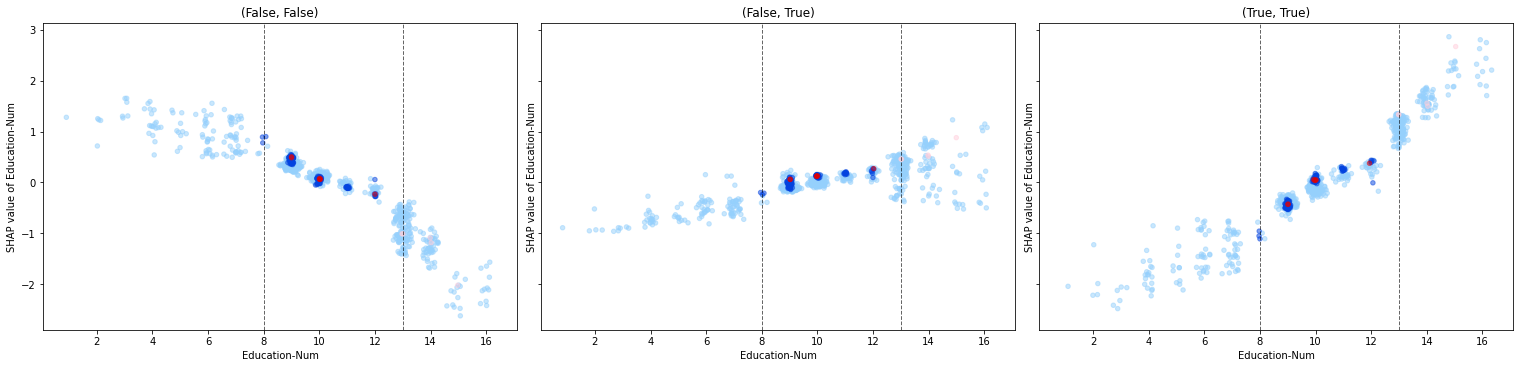

In [79]:
plot(next(feature_it))

4.0 <= Workclass <= 5.0
[Upper CF: Workclass == 6.0 --> {'(False, False)': 7}]


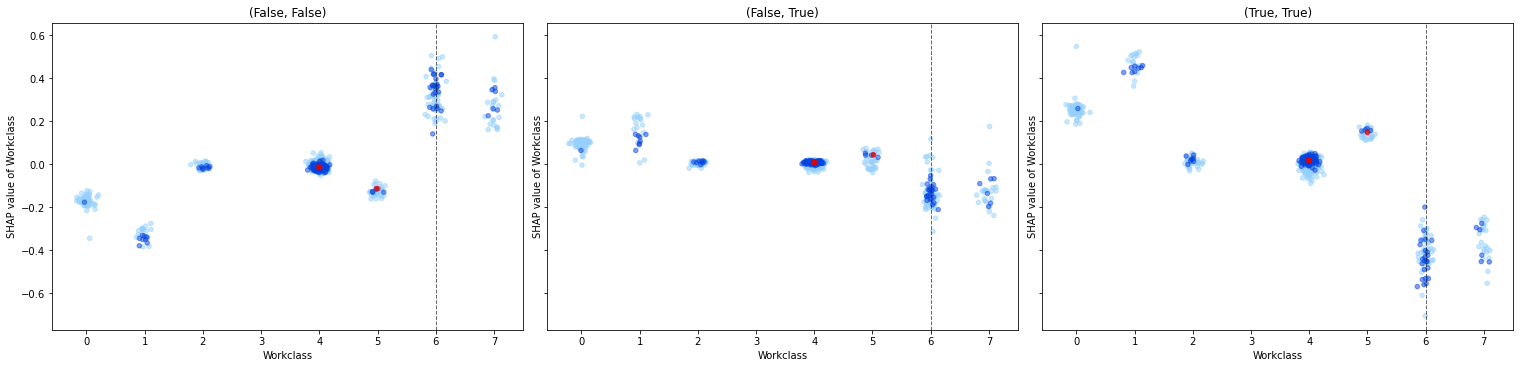

In [80]:
plot(next(feature_it))

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 7}]


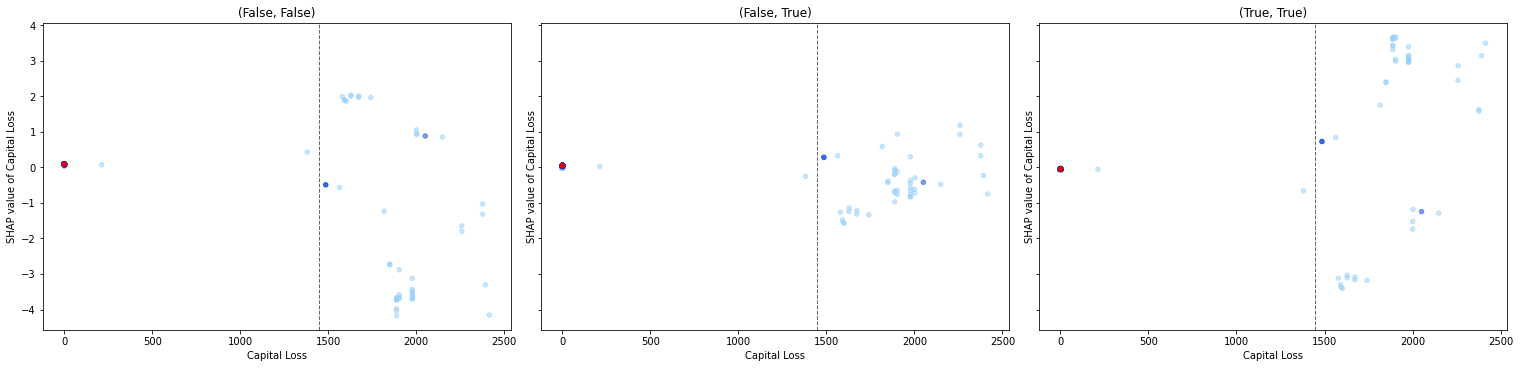

In [81]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 7}]


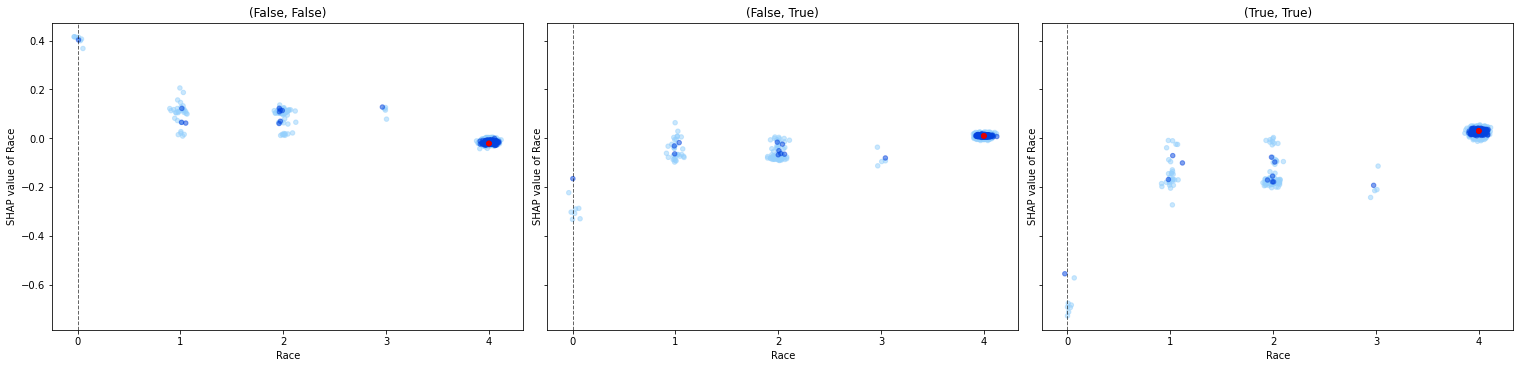

In [82]:
plot(next(feature_it))

Here too, Marital Status CF is missing.

In [83]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain', 'Workclass')
print(rule)
node.parent.evaluate_rules(rule)

Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.70      0.83       166
        True       0.12      1.00      0.22         7

    accuracy                           0.72       173
   macro avg       0.56      0.85      0.52       173
weighted avg       0.96      0.72      0.80       173



Precision    Recall  F1 Score  Support
False      1.000  0.704819  0.826855      166
True       0.125  1.000000  0.222222        7

In [84]:
explanations_l2.append((rule, constraint, instance_indices))

### Evaluation

#### Global

In [131]:
level = 0
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [132]:
print_rules(rules)
node.root.evaluate_rules(*rules);

1. 27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       965
        True       0.04      1.00      0.08        12

    accuracy                           0.73       977
   macro avg       0.52      0.86      0.46       977
weighted avg       0.99      0.73      0.83       977



In [133]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
statistics

invalid value encountered in true_divide


RMSE       BMR  BAR
Age               21.245588  0.000000  0.0
Workclass               NaN  1.000000  NaN
Education-Num      3.201562  0.478261  0.0
Marital Status          NaN  1.000000  NaN
Occupation              NaN  1.000000  NaN
Relationship            NaN  1.000000  NaN
Race                    NaN  1.000000  NaN
Sex                     NaN  1.000000  NaN
Capital Gain    6718.266015  0.076923  0.0
Capital Loss            NaN  1.000000  NaN
Hours per week     0.000000  0.000000  0.0
Country                 NaN  1.000000  NaN

In [134]:
get_complexity(constraints)

Rules          1
Constraints    6
dtype: int64

In [135]:
with open('explanation-shap-orig-01-l0.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [136]:
indices = node.root.instance_indices[node.root.highlight]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

In [137]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    12
Name: test, dtype: int64


In [138]:
errors, statistics = calc_constraint_error(feature_names, constraints_orig, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [139]:
fidelities_to_orig[(level, node.diff_class)] = statistics
statistics

RMSE  BMR  BAR
Age              0.0  0.0  0.0
Workclass        NaN  NaN  NaN
Education-Num    0.0  0.0  0.0
Marital Status   NaN  NaN  NaN
Occupation       NaN  NaN  NaN
Relationship     NaN  NaN  NaN
Race             NaN  NaN  NaN
Sex              NaN  NaN  NaN
Capital Gain     0.0  0.0  0.0
Capital Loss     NaN  NaN  NaN
Hours per week   0.0  0.0  0.0
Country          NaN  NaN  NaN

In [140]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  0.0        NaN            0.0             NaN         NaN   
  upper  0.0        NaN            NaN             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           NaN   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   

         Country  
1 lower      NaN  
  upper      NaN

#### Level 1

In [141]:
level = 1
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [142]:
print_rules(rules)
node.root.evaluate_rules(*rules);

1. Relationship <= 3.0 and `Education-Num` > 13.0 and 29.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0
              precision    recall  f1-score   support

       False       1.00      0.88      0.94       965
        True       0.09      1.00      0.17        12

    accuracy                           0.88       977
   macro avg       0.55      0.94      0.55       977
weighted avg       0.99      0.88      0.93       977



In [143]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
statistics

invalid value encountered in true_divide


RMSE       BMR  BAR
Age               21.170931  0.000000  0.0
Workclass               NaN  1.000000  NaN
Education-Num      2.458751  0.043478  0.0
Marital Status          NaN  1.000000  NaN
Occupation         1.000000  0.826087  0.0
Relationship       1.258306  0.368421  0.0
Race                    NaN  1.000000  NaN
Sex                0.000000  0.777778  0.0
Capital Gain    2025.633419  0.076923  0.0
Capital Loss            NaN  1.000000  NaN
Hours per week     0.000000  0.000000  0.0
Country                 NaN  1.000000  NaN

In [144]:
get_complexity(constraints)

Rules           2
Constraints    18
dtype: int64

In [145]:
with open('explanation-shap-orig-01-l1.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [146]:
indices = node.root.instance_indices[node.root.highlight]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

In [147]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    2
Name: test, dtype: int64
rule 2:
2    10
Name: test, dtype: int64


In [148]:
errors, statistics = calc_constraint_error(feature_names, constraints_orig, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [149]:
fidelities_to_orig[(level, node.diff_class)] = statistics
statistics

RMSE  BMR  BAR
Age             7.826238  0.0  0.0
Workclass            NaN  NaN  NaN
Education-Num   0.000000  0.0  0.0
Marital Status       NaN  1.0  NaN
Occupation      0.000000  0.0  0.0
Relationship    2.121320  0.0  0.0
Race                 NaN  NaN  NaN
Sex             0.000000  0.0  0.0
Capital Gain    0.000000  0.0  0.0
Capital Loss         NaN  NaN  NaN
Hours per week  0.000000  0.0  0.0
Country              NaN  NaN  NaN

In [150]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  -7.0        NaN            0.0             NaN         0.0   
  upper  14.0        NaN            NaN             NaN         0.0   
2 lower   0.0        NaN            0.0             NaN         NaN   
  upper   0.0        NaN            0.0             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           NaN   NaN  0.0           NaN           NaN             0.0   
  upper           3.0   NaN  NaN           0.0           NaN             0.0   
2 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   

         Country  
1 lower      NaN  
  upper      NaN  
2 lower      NaN  
  upper      NaN

#### Level 2

In [151]:
level = 2
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [152]:
print_rules(rules)
node.root.evaluate_rules(*rules);

1. Relationship <= 3.0 and `Education-Num` > 13.0 and 29.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 39.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and Workclass > 1.0
3. Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.94      0.97       965
        True       0.16      1.00      0.28        12

    accuracy                           0.94       977
   macro avg       0.58      0.97      0.62       977
weighted avg       0.99      0.94      0.96       977



In [153]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
statistics

invalid value encountered in true_divide


RMSE       BMR  BAR
Age               12.820881  0.000000  0.0
Workclass          0.000000  0.550000  0.1
Education-Num      1.066004  0.043478  0.0
Marital Status          NaN  1.000000  NaN
Occupation         1.000000  0.826087  0.0
Relationship       1.258306  0.368421  0.0
Race                    NaN  1.000000  NaN
Sex                0.000000  0.777778  0.0
Capital Gain    2025.633419  0.076923  0.0
Capital Loss            NaN  1.000000  NaN
Hours per week     0.000000  0.000000  0.0
Country                 NaN  1.000000  NaN

In [154]:
get_complexity(constraints)

Rules           3
Constraints    28
dtype: int64

In [155]:
with open('explanation-shap-orig-01-l2.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [156]:
indices = node.root.instance_indices[node.root.highlight]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

In [157]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    2
Name: test, dtype: int64
rule 2:
2    3
Name: test, dtype: int64
rule 3:
3    7
Name: test, dtype: int64


In [158]:
errors, statistics = calc_constraint_error(feature_names, constraints_orig, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [159]:
fidelities_to_orig[(level, node.diff_class)] = statistics
statistics

RMSE  BMR  BAR
Age             6.595453  0.0  0.0
Workclass       0.000000  0.0  0.5
Education-Num   0.000000  0.0  0.0
Marital Status       NaN  1.0  NaN
Occupation      0.000000  0.0  0.0
Relationship    1.732051  0.0  0.0
Race                 NaN  NaN  NaN
Sex             0.000000  0.0  0.0
Capital Gain    0.000000  0.0  0.0
Capital Loss         NaN  NaN  NaN
Hours per week  0.000000  0.0  0.0
Country              NaN  NaN  NaN

In [160]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  -7.0        NaN            0.0             NaN         0.0   
  upper  14.0        NaN            NaN             NaN         0.0   
2 lower   0.0        NaN            0.0             NaN         NaN   
  upper  -4.0        NaN            0.0             NaN         NaN   
3 lower   0.0        NaN            0.0             NaN         NaN   
  upper   0.0        0.0            0.0             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           NaN   NaN  0.0           NaN           NaN             0.0   
  upper           3.0   NaN  NaN           0.0           NaN             0.0   
2 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   
3 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   

         Country  
1 lower      NaN  
  upper      NaN  
2 lower      NaN  
  upper      NaN  
3 lower      NaN  
  upper      NaN

# Summary

In [163]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 0:
        level = 'global'
    elif depth == 2:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Stability

In [162]:
fidelity_to_orig = pd.concat(fidelities_to_orig.values(), keys=fidelities_to_orig.keys(), names=('depth', 'class', 'feature'))
fidelity_to_orig = fidelity_to_orig.reorder_levels(['class', 'depth', 'feature']).sort_index()
fidelity_to_orig

RMSE  BMR  BAR
class         depth feature                           
(False, True) 0     Age             0.000000  0.0  0.0
                    Capital Gain    0.000000  0.0  0.0
                    Capital Loss         NaN  NaN  NaN
                    Country              NaN  NaN  NaN
                    Education-Num   0.000000  0.0  0.0
                    Hours per week  0.000000  0.0  0.0
                    Marital Status       NaN  NaN  NaN
                    Occupation           NaN  NaN  NaN
                    Race                 NaN  NaN  NaN
                    Relationship         NaN  NaN  NaN
                    Sex                  NaN  NaN  NaN
                    Workclass            NaN  NaN  NaN
              1     Age             7.826238  0.0  0.0
                    Capital Gain    0.000000  0.0  0.0
                    Capital Loss         NaN  NaN  NaN
                    Country              NaN  NaN  NaN
                    Education-Num   0.000000  0.0  0.0
                    Hours per week  0.000000  0.0  0.0
                    Marital Status       NaN  1.0  NaN
                    Occupation      0.000000  0.0  0.0
                    Race                 NaN  NaN  NaN
                    Relationship    2.121320  0.0  0.0
                    Sex             0.000000  0.0  0.0
                    Workclass            NaN  NaN  NaN
              2     Age             6.595453  0.0  0.0
                    Capital Gain    0.000000  0.0  0.0
                    Capital Loss         NaN  NaN  NaN
                    Country              NaN  NaN  NaN
                    Education-Num   0.000000  0.0  0.0
                    Hours per week  0.000000  0.0  0.0
                    Marital Status       NaN  1.0  NaN
                    Occupation      0.000000  0.0  0.0
                    Race                 NaN  NaN  NaN
                    Relationship    1.732051  0.0  0.0
                    Sex             0.000000  0.0  0.0
                    Workclass       0.000000  0.0  0.5

In [164]:
fidelity_to_orig.index = fidelity_to_orig.index.map(map_index)
fidelity_to_orig = fidelity_to_orig[fidelity_to_orig.index.get_level_values('depth').notnull()]
fidelity_to_orig.index.rename(['class', 'level', 'feature'], inplace=True)

with open('results.proposed.test.pickle', 'wb') as f:
    pickle.dump(fidelity_to_orig, f)